In [1]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[-0.6398]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.8709]], requires_grad=True)
alpha:  tensor([0.3930])
gt ols coef:  [[-0.63485026]]
gt ols intercept:  [-0.81396824]
trunc ols coef:  [[-0.27256936]]
trunc ols intercept:  [1.5339618]


Text(0, 0.5, 'y')

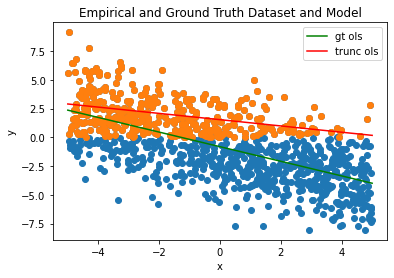

In [5]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))

    y = gt(X)

noise_var = Tensor([5.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [4]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9916)
beta:  tensor(4.9916)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([2.4027])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

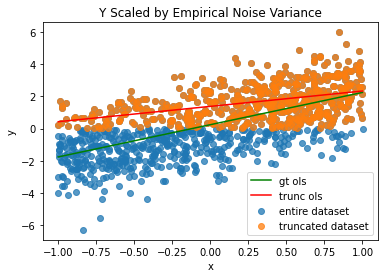

In [5]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4805])
reg noise var:  tensor([0.9624])


Text(0, 0.5, 'y')

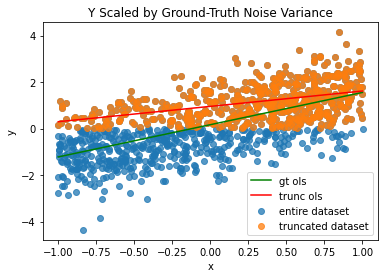

In [6]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [7]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * ch.sqrt(emp_noise_var))

0 steps | score: [0.21396589279174805]
100 steps | score: [0.12902069091796875]
200 steps | score: [0.08731332421302795]
300 steps | score: [0.007806718349456787]
400 steps | score: [0.03827406466007233]
500 steps | score: [0.05123590677976608]
600 steps | score: [0.05245800316333771]
700 steps | score: [0.09803733974695206]
800 steps | score: [0.06443636119365692]
900 steps | score: [0.07019159942865372]
1000 steps | score: [0.08759771287441254]


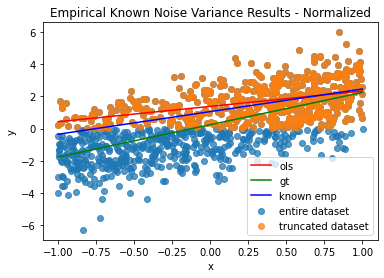

Text(0, 0.5, 'y')

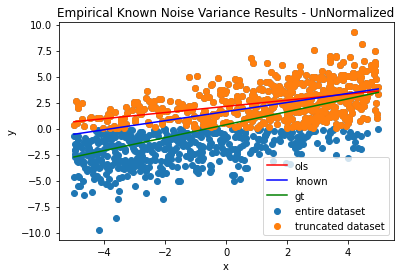

In [8]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [9]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, val=10, bs=100, n=1, tol=1e-2)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * ch.sqrt(noise_var)

0 steps | score: [0.22792524099349976]
1 steps | score: [0.2949662506580353]
2 steps | score: [0.2621906101703644]
3 steps | score: [0.2080284059047699]
4 steps | score: [0.23872174322605133]
5 steps | score: [0.18210293352603912]
6 steps | score: [0.2085130214691162]
7 steps | score: [0.14472460746765137]
8 steps | score: [0.2240763157606125]
9 steps | score: [0.15688711404800415]
10 steps | score: [0.16034062206745148]
11 steps | score: [0.14710168540477753]
12 steps | score: [0.18119260668754578]
13 steps | score: [0.10140843689441681]
14 steps | score: [0.10847195237874985]
15 steps | score: [0.09841840714216232]
16 steps | score: [0.1279100775718689]
17 steps | score: [0.12686927616596222]
18 steps | score: [0.06960474699735641]
19 steps | score: [0.15381039679050446]
20 steps | score: [0.12468279153108597]
21 steps | score: [0.10570991784334183]
22 steps | score: [0.051160745322704315]
23 steps | score: [0.05610969290137291]
24 steps | score: [0.09964567422866821]
25 steps | scor

273 steps | score: [-0.02597793936729431]
274 steps | score: [0.024449782446026802]
275 steps | score: [0.01679632067680359]
276 steps | score: [0.0008333530277013779]
277 steps | score: [0.057054903358221054]
278 steps | score: [-0.037568531930446625]
279 steps | score: [0.05349735915660858]
280 steps | score: [0.023959243670105934]
281 steps | score: [0.014926321804523468]
282 steps | score: [0.03855067119002342]
283 steps | score: [0.0671711415052414]
284 steps | score: [0.0706542432308197]
285 steps | score: [0.02388918586075306]
286 steps | score: [0.02325756475329399]
287 steps | score: [0.019921734929084778]
288 steps | score: [0.05201120302081108]
289 steps | score: [0.02606736496090889]
290 steps | score: [0.04196438565850258]
291 steps | score: [0.04703817516565323]
292 steps | score: [0.0074427779763937]
293 steps | score: [0.018532728776335716]
294 steps | score: [0.03266746550798416]
295 steps | score: [0.04913664609193802]
296 steps | score: [0.016563888639211655]
297 ste

481 steps | score: [0.03362830728292465]
482 steps | score: [0.03242761641740799]
483 steps | score: [0.05110327526926994]
484 steps | score: [0.0020140260457992554]
485 steps | score: [0.021153971552848816]
486 steps | score: [0.02494627982378006]
487 steps | score: [0.023896321654319763]
488 steps | score: [-0.011196300387382507]
489 steps | score: [0.02521386556327343]
490 steps | score: [0.03734341263771057]
491 steps | score: [-0.03936251625418663]
492 steps | score: [0.002857208251953125]
493 steps | score: [0.04861506074666977]
494 steps | score: [0.02275863289833069]
495 steps | score: [0.00911550223827362]
496 steps | score: [0.0574294812977314]
497 steps | score: [0.03830121457576752]
498 steps | score: [0.02008000575006008]
499 steps | score: [-0.004075948148965836]
500 steps | score: [0.03017093800008297]
501 steps | score: [-0.010363306850194931]
502 steps | score: [0.017443668097257614]
503 steps | score: [0.007878076285123825]
504 steps | score: [-0.006684970110654831]
5

695 steps | score: [0.042436759918928146]
696 steps | score: [0.03614497929811478]
697 steps | score: [0.02266758307814598]
698 steps | score: [-0.016355715692043304]
699 steps | score: [-0.0021387040615081787]
700 steps | score: [0.07268598675727844]
701 steps | score: [0.027193276211619377]
702 steps | score: [0.02192355878651142]
703 steps | score: [0.058335911482572556]
704 steps | score: [0.04199270159006119]
705 steps | score: [0.050817206501960754]
706 steps | score: [0.050887856632471085]
707 steps | score: [0.030434057116508484]
708 steps | score: [0.03620852530002594]
709 steps | score: [0.02891785278916359]
710 steps | score: [0.027724657207727432]
711 steps | score: [0.010398704558610916]
712 steps | score: [0.09271533042192459]
713 steps | score: [0.01701303757727146]
714 steps | score: [0.022657616063952446]
715 steps | score: [0.038127101957798004]
716 steps | score: [0.05423532426357269]
717 steps | score: [-0.018958404660224915]
718 steps | score: [-0.00367708876729011

903 steps | score: [0.04355330765247345]
904 steps | score: [0.01662503182888031]
905 steps | score: [0.02281426079571247]
906 steps | score: [-0.012518681585788727]
907 steps | score: [0.03886164724826813]
908 steps | score: [0.03609493374824524]
909 steps | score: [0.05443263053894043]
910 steps | score: [-0.003424406051635742]
911 steps | score: [-0.017703909426927567]
912 steps | score: [0.05033386871218681]
913 steps | score: [0.039386823773384094]
914 steps | score: [0.006775885820388794]
915 steps | score: [0.057025518268346786]
916 steps | score: [-0.0023002997040748596]
917 steps | score: [0.037724047899246216]
918 steps | score: [0.008647460490465164]
919 steps | score: [0.050553034991025925]
920 steps | score: [0.06465011090040207]
921 steps | score: [0.03931897506117821]
922 steps | score: [0.030704814940690994]
923 steps | score: [0.023311646655201912]
924 steps | score: [0.07336388528347015]
925 steps | score: [0.0414448082447052]
926 steps | score: [0.023537738248705864]

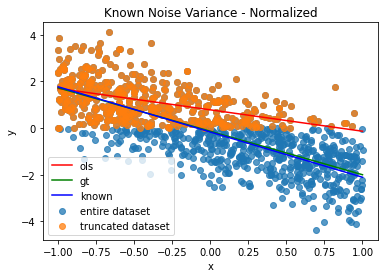

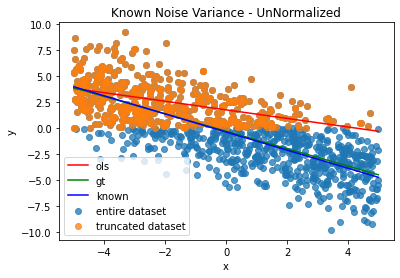

In [10]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [25]:
trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=True, unknown=True, bs=100, n=10, tol=1e-2, val=10, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * ch.sqrt(emp_noise_var)) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * ch.sqrt(emp_noise_var)).detach().numpy()

0 steps | score: [0.07770762592554092, -0.111968033015728]
10 steps | score: [-0.015211671590805054, 0.10884328186511993]
20 steps | score: [-0.03479945659637451, 0.15274977684020996]
30 steps | score: [-0.0038830898702144623, 0.03264313191175461]
40 steps | score: [-0.043718915432691574, 0.1272171437740326]
50 steps | score: [-0.04175432771444321, 0.10144871473312378]
60 steps | score: [0.05597959831357002, -0.12434219568967819]
70 steps | score: [-0.026684921234846115, 0.10233378410339355]
80 steps | score: [-0.03361361473798752, 0.07169242948293686]
90 steps | score: [0.05024251714348793, -0.10881216824054718]
100 steps | score: [-0.09872782230377197, 0.19719107449054718]
110 steps | score: [-0.07058897614479065, 0.17554223537445068]
120 steps | score: [-0.014901414513587952, 0.018000751733779907]
130 steps | score: [-0.07098206877708435, 0.1597038209438324]
140 steps | score: [-0.008060965687036514, -0.021449148654937744]
150 steps | score: [0.01843872293829918, -0.0623303875327110

1340 steps | score: [-0.01400713436305523, -0.0558122843503952]
1350 steps | score: [-0.08481942117214203, 0.15662620961666107]
1360 steps | score: [-0.0764402449131012, 0.14082351326942444]
1370 steps | score: [-0.021166086196899414, 0.022645816206932068]
1380 steps | score: [0.0054030641913414, -0.07436034083366394]
1390 steps | score: [-0.049138426780700684, 0.050974342972040176]
1400 steps | score: [-0.07839575409889221, 0.13464291393756866]
1410 steps | score: [-0.03305252268910408, 0.026697207242250443]
1420 steps | score: [-0.07760383188724518, 0.10051722824573517]
1430 steps | score: [-0.015680477023124695, -0.060201071202754974]
1440 steps | score: [-0.04532398283481598, 0.05143383517861366]
1450 steps | score: [-0.05975762754678726, 0.15153823792934418]
1460 steps | score: [-0.03191012889146805, 0.0001558065414428711]
1470 steps | score: [-0.014606371521949768, -0.019187040627002716]
1480 steps | score: [-0.06064256280660629, 0.13444608449935913]
1490 steps | score: [-0.05573

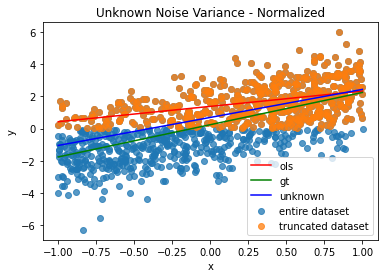

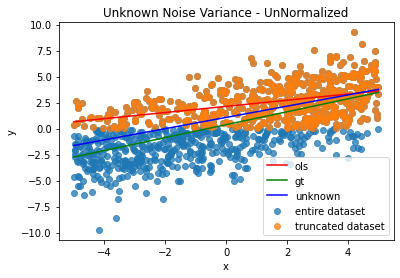

In [26]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [28]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 20)
args.__setattr__('samples', 10000)

EXP = 'Checking Something 5_'

In [ ]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 5, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
# dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'known_emp_r2': float,
#         'known_emp_param_mse': float,
#         'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })
    
    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
    gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None
    
    # create base classifier
    with ch.no_grad():
        # generate data
        X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
        y = gt(X)
        
    for noise_var in range(1, 21): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*ch.randn(X.size(0), 1)
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        print("gt params: ", gt_params)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
#         emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(ols_var)
#         # standardize noised by the empirical noise variance
#         emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
#         trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, args=args, bias=args.bias, var=ch.ones(1))
#         st = datetime.datetime.now()
#         known_emp_results = trunc_reg.fit(x_trunc, y_trunc)
#         w, w0 = (known_emp_results.weight.detach().cpu()), known_emp_results.bias.detach().cpu()[..., None]
#         known_emp_params = ch.cat([w, w0], dim=1).flatten()
#         # known emp results
#         store[TABLE_NAME].update_row({
#             'known_emp_r2': r2_score(noised.flatten(), X@w.T + w0), 
#             'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
#             'known_emp_time': int((datetime.datetime.now() - st).total_seconds()), 
#         })
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / math.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        stand_noised = noised / math.sqrt(noise_var)
        trunc_reg = trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=False, bs=args.bs, n=100, tol=args.tol, steps=args.steps)
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * math.sqrt(noise_var)) / beta, known_results.bias.detach().cpu()[..., None] * math.sqrt(noise_var)
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # truncated regression with unknown variance
        trunc_reg = TruncatedRegression(phi=phi, alpha=alpha, bias=args.bias, unknown=True, bs=args.bs, n=100, tol=args.tol, steps=args.steps)
        st = datetime.datetime.now()
        unknown_results = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

        var_ = unknown_results.lambda_.inverse()
        unknown_var = var_ * ols_var
        w, w0 = (((unknown_results.weight * var_) * ch.sqrt(ols_var)) / beta).detach(), ((unknown_results.bias * ch.sqrt(ols_var))).detach()
        unknown_params = ch.cat([w, w0], dim=1).flatten()
        print("unknown params: ", unknown_params)
        print("gt params: ", gt_params)
        print("ols params: ", ols_params)
        print("unknown mse: ", mse_loss(unknown_params, gt_params))
        print("ols mse: ", mse_loss(ols_params, gt_params))
        
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/Checking Something 5_/ccbbfce7-f95d-4641-92f1-03f3573c3459
gt params:  tensor([ 0.1085,  0.2555,  0.6003, -0.6642,  0.4846,  0.6192])
0 steps | score: [0.22124223411083221]
100 steps | score: [0.011381406337022781]
200 steps | score: [0.1283445954322815]
300 steps | score: [0.10474556684494019]
400 steps | score: [0.19839152693748474]
500 steps | score: [0.06396964192390442]
600 steps | score: [0.0909557044506073]
700 steps | score: [0.03309105336666107]
800 steps | score: [0.06927433609962463]
900 steps | score: [0.12008286267518997]
1000 steps | score: [0.16453717648983002]
1100 steps | score: [0.06924748420715332]
1200 steps | score: [0.08851287513971329]
1300 steps | score: [0.11269135773181915]
1400 steps | score: [0.14181354641914368]
1500 steps | score: [0.05487704277038574]
1600 steps | score: [0.08009228855371475]
1700 steps | score: [0.10548804700374603]
1800 steps | score: [0.06910786032676697]
1900 steps | score: [0.063565999269

100 steps | score: [-0.3894366919994354, 1.7398197650909424]
200 steps | score: [-0.5315139889717102, 2.0777180194854736]
300 steps | score: [-0.48381751775741577, 1.9432371854782104]
400 steps | score: [-0.5851250886917114, 2.2070841789245605]
500 steps | score: [-0.2490818202495575, 1.2361127138137817]
600 steps | score: [-0.2634950578212738, 1.2900598049163818]
700 steps | score: [-0.6198322772979736, 2.2687430381774902]
800 steps | score: [-0.18957802653312683, 1.053268313407898]
900 steps | score: [-0.38219964504241943, 1.69663667678833]
1000 steps | score: [-0.3227402865886688, 1.4780232906341553]
1100 steps | score: [0.010677785612642765, 0.37832194566726685]
1200 steps | score: [-0.36419227719306946, 1.5728354454040527]
1300 steps | score: [-0.18833458423614502, 1.0417015552520752]
1400 steps | score: [-0.27096766233444214, 1.3009990453720093]
1500 steps | score: [-0.3233443796634674, 1.441108226776123]
1600 steps | score: [-0.09276354312896729, 0.7703139185905457]
1700 steps |

1200 steps | score: [0.06676126271486282]
1300 steps | score: [0.08237994462251663]
1400 steps | score: [0.10944613814353943]
1500 steps | score: [0.0787467435002327]
1600 steps | score: [0.06818431615829468]
1700 steps | score: [0.0741620808839798]
1800 steps | score: [0.07398886978626251]
1900 steps | score: [0.10224637389183044]
2000 steps | score: [0.11063241213560104]
2100 steps | score: [0.08766447752714157]
2200 steps | score: [0.0803927332162857]
2300 steps | score: [0.07769878208637238]
2400 steps | score: [0.07980062812566757]
2500 steps | score: [0.10299474745988846]
2600 steps | score: [0.10815706849098206]
2700 steps | score: [0.09698567539453506]
0 steps | score: [-0.11834924668073654, 0.46116459369659424]
100 steps | score: [-0.052639465779066086, 0.10713449120521545]
200 steps | score: [-0.08285759389400482, 0.0778837502002716]
300 steps | score: [-0.08223272114992142, 0.11118049919605255]
400 steps | score: [-0.1062169224023819, 0.052340105175971985]
500 steps | score:

2100 steps | score: [-0.1971803605556488]
2200 steps | score: [-0.16265185177326202]
2300 steps | score: [-0.14629095792770386]
2400 steps | score: [-0.1416066437959671]
2500 steps | score: [-0.15897433459758759]
2600 steps | score: [-0.15274183452129364]
2700 steps | score: [-0.1267346739768982]
0 steps | score: [0.020813018083572388, 0.04383870214223862]
100 steps | score: [-0.12489760667085648, 0.2553664445877075]
200 steps | score: [-0.19786956906318665, 0.32965272665023804]
300 steps | score: [-0.13565243780612946, 0.18798092007637024]
400 steps | score: [-0.17463143169879913, 0.2766195237636566]
500 steps | score: [-0.15771549940109253, 0.21825076639652252]
600 steps | score: [-0.10974430292844772, 0.14721977710723877]
700 steps | score: [-0.3266131281852722, 0.5503675937652588]
800 steps | score: [-0.12900419533252716, 0.17573896050453186]
900 steps | score: [0.005196810699999332, -0.1763521283864975]
1000 steps | score: [-0.21799397468566895, 0.3365243673324585]
1100 steps | sc

1500 steps | score: [0.07905393838882446]
1600 steps | score: [0.11065398901700974]
1700 steps | score: [0.096174456179142]
1800 steps | score: [0.11079123616218567]
1900 steps | score: [0.15528987348079681]
2000 steps | score: [0.09457636624574661]
2100 steps | score: [0.11074164509773254]
2200 steps | score: [0.12620829045772552]
2300 steps | score: [0.12123255431652069]
2400 steps | score: [0.11891941726207733]
2500 steps | score: [0.11843222379684448]
2600 steps | score: [0.10710006952285767]
2700 steps | score: [0.11829058825969696]
0 steps | score: [0.285421758890152, -0.29670214653015137]
100 steps | score: [-0.12590987980365753, 0.41246554255485535]
200 steps | score: [0.0724528431892395, -0.05073259398341179]
300 steps | score: [-0.0462208054959774, 0.20216479897499084]
400 steps | score: [0.07398885488510132, -0.06590414047241211]
500 steps | score: [-0.024642007425427437, 0.1585511565208435]
600 steps | score: [0.025535771623253822, 0.04489339143037796]
700 steps | score: [0

200 steps | score: [-0.13095255196094513]
300 steps | score: [-0.07038222998380661]
400 steps | score: [-0.06745017319917679]
500 steps | score: [-0.1065218448638916]
600 steps | score: [-0.1216036006808281]
700 steps | score: [-0.08608990907669067]
800 steps | score: [-0.07888159155845642]
900 steps | score: [-0.07261751592159271]
1000 steps | score: [-0.06616833806037903]
1100 steps | score: [-0.1017797589302063]
1200 steps | score: [-0.1300712674856186]
1300 steps | score: [-0.1141270101070404]
1400 steps | score: [-0.0943940207362175]
1500 steps | score: [-0.08136902749538422]
1600 steps | score: [-0.11452789604663849]
1700 steps | score: [-0.10143503546714783]
1800 steps | score: [-0.08149206638336182]
1900 steps | score: [-0.08553886413574219]
2000 steps | score: [-0.09604048728942871]
2100 steps | score: [-0.09642285108566284]
2200 steps | score: [-0.11886445432901382]
2300 steps | score: [-0.11059023439884186]
2400 steps | score: [-0.11751450598239899]
2500 steps | score: [-0.0

1100 steps | score: [-0.06514465808868408, 0.1625629961490631]
1200 steps | score: [-0.012963001616299152, 0.06452777236700058]
1300 steps | score: [0.13843189179897308, -0.28293341398239136]
1400 steps | score: [0.08727995306253433, -0.1751219928264618]
1500 steps | score: [0.003545238869264722, 0.003751881420612335]
unknown params:  tensor([ 0.1372,  0.2276,  0.5718, -0.5982,  0.4913,  0.3781])
gt params:  tensor([ 0.0918,  0.2429,  0.6027, -0.6616,  0.5055,  0.5842])
ols params:  tensor([ 0.0633,  0.1220,  0.2967, -0.3144,  0.2559,  3.6883])
unknown mse:  tensor(0.0083)
ols mse:  tensor(1.6545)
gt params:  tensor([ 0.0955,  0.2399,  0.5834, -0.6424,  0.5022,  0.5280])
0 steps | score: [0.36972373723983765]
100 steps | score: [0.06697064638137817]
200 steps | score: [0.11767283082008362]
300 steps | score: [0.08156280964612961]
400 steps | score: [0.08974847197532654]
500 steps | score: [0.03818299621343613]
600 steps | score: [0.11042632162570953]
700 steps | score: [0.0393169485032

1500 steps | score: [0.03297872096300125, 0.06256595253944397]
1600 steps | score: [0.25496068596839905, -0.3950262665748596]
1700 steps | score: [0.20599791407585144, -0.24252194166183472]
1800 steps | score: [0.2258988618850708, -0.324148565530777]
1900 steps | score: [0.20143115520477295, -0.30182188749313354]
2000 steps | score: [0.15937753021717072, -0.19949829578399658]
2100 steps | score: [0.13269630074501038, -0.12537743151187897]
2200 steps | score: [0.25267788767814636, -0.37633851170539856]
2300 steps | score: [0.13930027186870575, -0.14309494197368622]
2400 steps | score: [0.12168026715517044, -0.12003156542778015]
2500 steps | score: [0.17187821865081787, -0.2150726318359375]
2600 steps | score: [0.20149226486682892, -0.29194706678390503]
unknown params:  tensor([ 0.1138,  0.2387,  0.5754, -0.6448,  0.4770,  0.3543])
gt params:  tensor([ 0.1182,  0.2373,  0.6038, -0.6485,  0.4907,  0.5074])
ols params:  tensor([ 0.0574,  0.1188,  0.2821, -0.3114,  0.2338,  3.9054])
unknown

1500 steps | score: [-0.02538689598441124, -0.24400568008422852]
1600 steps | score: [-0.06794423609972, -0.1467166244983673]
1700 steps | score: [-0.02356637269258499, -0.24127566814422607]
1800 steps | score: [-0.04915023222565651, -0.19333823025226593]
1900 steps | score: [-0.03087649494409561, -0.21238678693771362]
2000 steps | score: [-0.02979940176010132, -0.2576460540294647]
2100 steps | score: [-0.14073780179023743, 0.042526498436927795]
2200 steps | score: [-0.06509797275066376, -0.13210688531398773]
2300 steps | score: [-0.09016355872154236, -0.09604546427726746]
2400 steps | score: [-0.03761798143386841, -0.22767142951488495]
2500 steps | score: [-0.007807652000337839, -0.2750176191329956]
2600 steps | score: [-0.10894779115915298, -0.0369827076792717]
2700 steps | score: [-0.013421623967587948, -0.3137126564979553]
2800 steps | score: [-0.10790134221315384, -0.07302892208099365]
2900 steps | score: [-0.014293673448264599, -0.28959283232688904]
unknown params:  tensor([-0.76

1800 steps | score: [-0.09029331058263779]
1900 steps | score: [-0.06838302314281464]
2000 steps | score: [-0.08433116972446442]
2100 steps | score: [-0.08140057325363159]
2200 steps | score: [-0.07252517342567444]
2300 steps | score: [-0.12450949102640152]
2400 steps | score: [-0.06879233568906784]
2500 steps | score: [-0.10254546254873276]
2600 steps | score: [-0.06679104268550873]
2700 steps | score: [-0.07758090645074844]
2800 steps | score: [-0.09126059710979462]
2900 steps | score: [-0.07948026061058044]
0 steps | score: [0.21905595064163208, -0.07483259588479996]
100 steps | score: [0.059276118874549866, 0.1203714907169342]
200 steps | score: [0.25371211767196655, -0.4539007842540741]
300 steps | score: [0.5083847045898438, -1.228617787361145]
400 steps | score: [0.5254474878311157, -1.3121823072433472]
500 steps | score: [-0.13823729753494263, 0.4487819969654083]
600 steps | score: [-0.044624414294958115, 0.28932708501815796]
700 steps | score: [0.10899879783391953, -0.11396171

100 steps | score: [0.15167243778705597, -0.1847778707742691]
200 steps | score: [-0.014875867404043674, 0.17174957692623138]
300 steps | score: [-0.12761220335960388, 0.3472115695476532]
400 steps | score: [-0.08618440479040146, 0.2603558599948883]
500 steps | score: [0.2130986899137497, -0.38123929500579834]
600 steps | score: [-0.21974091231822968, 0.5276752710342407]
700 steps | score: [0.13260555267333984, -0.20114877820014954]
800 steps | score: [0.008767747320234776, 0.03812490031123161]
900 steps | score: [-0.08941628783941269, 0.29247692227363586]
1000 steps | score: [0.09250947088003159, -0.107098788022995]
1100 steps | score: [-0.1737583875656128, 0.43111127614974976]
1200 steps | score: [0.07994590699672699, -0.13183806836605072]
1300 steps | score: [0.1199849396944046, -0.19245542585849762]
1400 steps | score: [-0.040515899658203125, 0.1614505797624588]
1500 steps | score: [0.08272704482078552, -0.12206120043992996]
1600 steps | score: [-0.10384277254343033, 0.287598162889

100 steps | score: [-0.01127314567565918]
200 steps | score: [0.04253321513533592]
300 steps | score: [-0.011922918260097504]
400 steps | score: [-0.030426282435655594]
500 steps | score: [-0.040146030485630035]
600 steps | score: [0.0019949637353420258]
0 steps | score: [0.18089941143989563, -0.08161485195159912]
100 steps | score: [0.18352283537387848, -0.23123610019683838]
200 steps | score: [-0.02515590935945511, 0.1523040533065796]
300 steps | score: [0.12683123350143433, -0.24515420198440552]
400 steps | score: [0.006934851408004761, 0.05588802695274353]
500 steps | score: [-0.15364570915699005, 0.41805732250213623]
600 steps | score: [0.03062383085489273, -0.00978212058544159]
700 steps | score: [-0.03086845390498638, 0.11437022686004639]
800 steps | score: [-0.05962607264518738, 0.16432426869869232]
900 steps | score: [0.142633318901062, -0.2635537087917328]
1000 steps | score: [0.1446709930896759, -0.2566969692707062]
1100 steps | score: [0.014665207825601101, 0.01212079823017

200 steps | score: [0.032978594303131104]
300 steps | score: [0.057438917458057404]
400 steps | score: [0.01178516075015068]
500 steps | score: [0.009326387196779251]
0 steps | score: [0.3238999843597412, -0.500566840171814]
100 steps | score: [0.19374863803386688, -0.3491165041923523]
200 steps | score: [0.36609846353530884, -0.8325767517089844]
300 steps | score: [0.3453224301338196, -0.859563946723938]
400 steps | score: [0.050264667719602585, -0.16267484426498413]
500 steps | score: [0.0017834523459896445, -0.07470422983169556]
600 steps | score: [0.051842182874679565, -0.15212436020374298]
700 steps | score: [0.06063031032681465, -0.2234744429588318]
800 steps | score: [0.17288616299629211, -0.46494078636169434]
900 steps | score: [0.17509211599826813, -0.4500279724597931]
1000 steps | score: [0.03991706669330597, -0.1682249903678894]
1100 steps | score: [0.020546743646264076, -0.12828928232192993]
1200 steps | score: [0.11790734529495239, -0.3332677483558655]
1300 steps | score: 

1700 steps | score: [0.042983122169971466, -0.032748639583587646]
1800 steps | score: [-0.2084723562002182, 0.4940783977508545]
1900 steps | score: [-0.0438092015683651, 0.1702219843864441]
2000 steps | score: [-0.041363295167684555, 0.11545784771442413]
2100 steps | score: [-0.01903221569955349, 0.11373884975910187]
2200 steps | score: [0.04598608985543251, -0.03984314203262329]
2300 steps | score: [-0.16601254045963287, 0.3978784680366516]
2400 steps | score: [-0.1058785691857338, 0.2995012402534485]
2500 steps | score: [0.05533985048532486, -0.06419031322002411]
2600 steps | score: [-0.05223270505666733, 0.16170910000801086]
2700 steps | score: [-0.015416537411510944, 0.0893884003162384]
2800 steps | score: [-0.11249355971813202, 0.2998809218406677]
2900 steps | score: [-0.13003331422805786, 0.335003137588501]
unknown params:  tensor([-0.7482,  0.3012, -0.1644,  0.4600,  0.0155, -0.0321])
gt params:  tensor([-0.7248,  0.3195, -0.2015,  0.4606,  0.0297, -0.0735])
ols params:  tensor(

100 steps | score: [0.09339077025651932]
200 steps | score: [0.1599644124507904]
300 steps | score: [0.07928172498941422]
400 steps | score: [0.0818767249584198]
500 steps | score: [0.0898447334766388]
600 steps | score: [0.08505550771951675]
700 steps | score: [0.10350637882947922]
800 steps | score: [0.10837643593549728]
900 steps | score: [0.07259460538625717]
1000 steps | score: [0.06943562626838684]
1100 steps | score: [0.08862033486366272]
1200 steps | score: [0.1401917189359665]
1300 steps | score: [0.08546927571296692]
1400 steps | score: [0.05985153093934059]
1500 steps | score: [0.08631448447704315]
1600 steps | score: [0.06595711410045624]
1700 steps | score: [0.08561523258686066]
1800 steps | score: [0.10003624111413956]
1900 steps | score: [0.08502573519945145]
2000 steps | score: [0.08710221946239471]
2100 steps | score: [0.09583012759685516]
2200 steps | score: [0.09724368155002594]
2300 steps | score: [0.09446965903043747]
2400 steps | score: [0.09764957427978516]
2500 

1900 steps | score: [0.19340263307094574, -0.4387524724006653]
2000 steps | score: [0.23421156406402588, -0.5666951537132263]
2100 steps | score: [0.14572598040103912, -0.319247841835022]
2200 steps | score: [0.2592802345752716, -0.6134099364280701]
2300 steps | score: [0.15802636742591858, -0.3238889276981354]
2400 steps | score: [0.11828381568193436, -0.24960321187973022]
2500 steps | score: [0.22321224212646484, -0.5421223044395447]
2600 steps | score: [0.16380971670150757, -0.36194849014282227]
2700 steps | score: [0.2517593801021576, -0.633182168006897]
2800 steps | score: [0.18415945768356323, -0.4258875846862793]
unknown params:  tensor([-0.4112,  0.0011, -0.7998,  0.2431,  0.0100, -0.1970])
gt params:  tensor([-0.3978, -0.0025, -0.7997,  0.2496,  0.0052, -0.2943])
ols params:  tensor([-2.9043e-01, -3.2496e-04, -5.2774e-01,  1.7439e-01,  5.4252e-03,
         9.1743e-01])
unknown mse:  tensor(0.0016)
ols mse:  tensor(0.2599)
gt params:  tensor([-0.3977,  0.0041, -0.7921,  0.2557,

1900 steps | score: [0.020014246925711632, -0.13509254157543182]
2000 steps | score: [-0.07779724150896072, 0.08856058120727539]
2100 steps | score: [-0.02973215840756893, -0.03596313297748566]
2200 steps | score: [0.035398077219724655, -0.24699807167053223]
2300 steps | score: [-0.05935823172330856, 0.06023235619068146]
2400 steps | score: [0.05949290469288826, -0.27814024686813354]
2500 steps | score: [0.004866697359830141, -0.1330096274614334]
2600 steps | score: [-0.010493590496480465, -0.11436666548252106]
2700 steps | score: [0.037084903568029404, -0.20386996865272522]
unknown params:  tensor([-0.4074, -0.0155, -0.7666,  0.2580, -0.0265, -0.2068])
gt params:  tensor([-0.3964, -0.0011, -0.7801,  0.2459, -0.0155, -0.3450])
ols params:  tensor([-0.2264, -0.0101, -0.3938,  0.1457, -0.0156,  1.7383])
unknown mse:  tensor(0.0033)
ols mse:  tensor(0.7547)
gt params:  tensor([-0.3742,  0.0108, -0.7895,  0.2459, -0.0046, -0.3468])
0 steps | score: [0.31792211532592773]
100 steps | score: 

200 steps | score: [0.05916822701692581]
300 steps | score: [0.057706620544195175]
400 steps | score: [0.013291139155626297]
500 steps | score: [0.005167849361896515]
0 steps | score: [0.1955982744693756, -0.1796903908252716]
100 steps | score: [0.3018791973590851, -0.584348201751709]
200 steps | score: [-0.1430085003376007, 0.2699832618236542]
300 steps | score: [-0.13059444725513458, 0.2650977373123169]
400 steps | score: [0.06133927404880524, -0.16186673939228058]
500 steps | score: [-0.07814034074544907, 0.1257510781288147]
600 steps | score: [-0.0052976771257817745, -0.022148344665765762]
700 steps | score: [-0.0021948469802737236, -0.05702437832951546]
800 steps | score: [0.1525142639875412, -0.37396857142448425]
900 steps | score: [0.019833896309137344, -0.07321880012750626]
1000 steps | score: [-0.1353653073310852, 0.2424357831478119]
1100 steps | score: [0.026657063513994217, -0.08991925418376923]
1200 steps | score: [-0.009530648589134216, -0.023783601820468903]
1300 steps | 

200 steps | score: [-0.05504714697599411]
300 steps | score: [-0.11201794445514679]
400 steps | score: [-0.1027170941233635]
500 steps | score: [-0.046163082122802734]
600 steps | score: [-0.05693824961781502]
700 steps | score: [-0.051274463534355164]
800 steps | score: [-0.11756113171577454]
900 steps | score: [-0.06542600691318512]
1000 steps | score: [-0.09145935624837875]
1100 steps | score: [-0.07831087708473206]
1200 steps | score: [-0.09159765392541885]
1300 steps | score: [-0.10262677073478699]
1400 steps | score: [-0.046166807413101196]
1500 steps | score: [-0.07534775137901306]
1600 steps | score: [-0.07481017708778381]
1700 steps | score: [-0.07876069843769073]
1800 steps | score: [-0.09851396083831787]
1900 steps | score: [-0.07474952191114426]
2000 steps | score: [-0.08942507207393646]
2100 steps | score: [-0.07268662750720978]
2200 steps | score: [-0.08389635384082794]
2300 steps | score: [-0.08169609308242798]
2400 steps | score: [-0.08482890576124191]
2500 steps | scor

500 steps | score: [0.007939747534692287, -0.058048948645591736]
600 steps | score: [0.16495901346206665, -0.3613843023777008]
700 steps | score: [0.31905466318130493, -0.6847675442695618]
800 steps | score: [0.06859961897134781, -0.17422328889369965]
900 steps | score: [0.3005649149417877, -0.7179697751998901]
1000 steps | score: [0.07580588757991791, -0.1900646686553955]
1100 steps | score: [0.15053719282150269, -0.32578223943710327]
1200 steps | score: [0.1434343308210373, -0.3179086446762085]
1300 steps | score: [0.1591438204050064, -0.34984228014945984]
1400 steps | score: [0.13949094712734222, -0.3293544054031372]
1500 steps | score: [0.2425536960363388, -0.5313470363616943]
1600 steps | score: [0.03834908828139305, -0.13609710335731506]
1700 steps | score: [0.2296142876148224, -0.48832231760025024]
1800 steps | score: [0.19867080450057983, -0.4371485710144043]
1900 steps | score: [0.1650645136833191, -0.37366342544555664]
2000 steps | score: [0.2578410804271698, -0.5728341341018

2600 steps | score: [0.16679608821868896]
2700 steps | score: [0.1619119942188263]
2800 steps | score: [0.15276481211185455]
0 steps | score: [0.11026377975940704, 0.009622380137443542]
100 steps | score: [0.42455968260765076, -0.8450320959091187]
200 steps | score: [-0.23642244935035706, 0.5392616391181946]
300 steps | score: [0.016205240041017532, -0.01360764354467392]
400 steps | score: [-0.04730508476495743, 0.08660515397787094]
500 steps | score: [-0.13777042925357819, 0.27611520886421204]
600 steps | score: [-0.11691854149103165, 0.2449822872877121]
700 steps | score: [-0.09745068103075027, 0.21937112510204315]
800 steps | score: [-0.20544105768203735, 0.411138653755188]
900 steps | score: [-0.283565878868103, 0.5762920379638672]
1000 steps | score: [-0.03344748541712761, 0.05276702344417572]
1100 steps | score: [-0.15894731879234314, 0.32402557134628296]
1200 steps | score: [0.03561825305223465, -0.09935428202152252]
1300 steps | score: [-0.02906826324760914, 0.03562460094690323

2800 steps | score: [-0.04189058765769005, 0.19184525310993195]
unknown params:  tensor([-0.3624, -0.0218, -0.8362,  0.2562, -0.0299, -0.1638])
gt params:  tensor([-0.3778,  0.0075, -0.8025,  0.2216,  0.0074, -0.3182])
ols params:  tensor([-0.1542, -0.0050, -0.3311,  0.1082, -0.0151,  3.4552])
unknown mse:  tensor(0.0048)
ols mse:  tensor(2.4207)
gt params:  tensor([-0.4016,  0.0226, -0.7992,  0.1949,  0.0060, -0.3303])
0 steps | score: [0.419222354888916]
100 steps | score: [0.11287261545658112]
200 steps | score: [0.040379006415605545]
300 steps | score: [0.046829771250486374]
400 steps | score: [0.046267151832580566]
500 steps | score: [0.11808010935783386]
600 steps | score: [0.07151833176612854]
700 steps | score: [0.07033024728298187]
800 steps | score: [0.037105973809957504]
900 steps | score: [0.05580461025238037]
1000 steps | score: [0.09077541530132294]
1100 steps | score: [0.10335104167461395]
1200 steps | score: [0.05034608393907547]
1300 steps | score: [0.04267939925193786

200 steps | score: [-0.23387567698955536, 1.1977767944335938]
300 steps | score: [-0.16083864867687225, 0.7710434794425964]
400 steps | score: [-0.10452906042337418, 0.5821171402931213]
500 steps | score: [-0.33913496136665344, 1.4512335062026978]
600 steps | score: [0.1439819633960724, -0.5973935723304749]
700 steps | score: [0.027985451743006706, -0.08208911120891571]
800 steps | score: [0.243723526597023, -0.8060511350631714]
900 steps | score: [0.10096870362758636, -0.3662123680114746]
1000 steps | score: [-0.2983555495738983, 1.2661266326904297]
1100 steps | score: [-0.024601874873042107, 0.1086258590221405]
1200 steps | score: [0.0625622421503067, -0.2699838876724243]
1300 steps | score: [-0.04558979347348213, 0.23476403951644897]
1400 steps | score: [0.029745198786258698, 0.03820271044969559]
1500 steps | score: [0.20438380539417267, -0.7545678615570068]
1600 steps | score: [-0.06952200084924698, 0.2980802655220032]
1700 steps | score: [-0.021353857591748238, 0.18216201663017273

300 steps | score: [0.024079052731394768, -0.19318196177482605]
400 steps | score: [-0.138545960187912, 0.2525191009044647]
500 steps | score: [-0.08758985996246338, 0.193384051322937]
600 steps | score: [-0.16969527304172516, 0.36659926176071167]
700 steps | score: [0.01643296517431736, -0.18240736424922943]
800 steps | score: [-0.06733401864767075, 0.04874211549758911]
900 steps | score: [-0.06886853277683258, 0.051902443170547485]
1000 steps | score: [-0.3033653199672699, 0.739940881729126]
1100 steps | score: [-0.030928969383239746, -0.032556384801864624]
1200 steps | score: [0.20786994695663452, -0.8556973338127136]
1300 steps | score: [-0.10387713462114334, 0.17590729892253876]
1400 steps | score: [-0.028185592964291573, -0.05362895131111145]
1500 steps | score: [-0.14784184098243713, 0.26546669006347656]
1600 steps | score: [0.022887106984853745, -0.22941814363002777]
1700 steps | score: [-0.03378535434603691, -0.041788771748542786]
1800 steps | score: [0.04300835728645325, -0.3

2700 steps | score: [-0.14701683819293976, 0.28489184379577637]
2800 steps | score: [-0.09447955340147018, 0.12918689846992493]
unknown params:  tensor([-0.8440,  0.5722, -0.6383, -0.3896, -0.3970,  0.5439])
gt params:  tensor([-0.8650,  0.5767, -0.6700, -0.4021, -0.4133,  0.7538])
ols params:  tensor([-0.5556,  0.3841, -0.4325, -0.2679, -0.2705,  2.7008])
unknown mse:  tensor(0.0077)
ols mse:  tensor(0.6697)
gt params:  tensor([-0.8444,  0.5892, -0.6699, -0.3880, -0.4071,  0.7074])
0 steps | score: [0.18071864545345306]
100 steps | score: [0.004416825249791145]
0 steps | score: [0.13206471502780914, -0.12862741947174072]
100 steps | score: [0.21411870419979095, -0.5802883505821228]
200 steps | score: [-0.07697255909442902, 0.1465449333190918]
300 steps | score: [-0.13517291843891144, 0.2809104025363922]
400 steps | score: [0.024673674255609512, -0.13327749073505402]
500 steps | score: [-0.0015518475556746125, -0.10201719403266907]
600 steps | score: [-0.08085072040557861, 0.1228694915

1900 steps | score: [0.058320458978414536]
2000 steps | score: [0.06546919792890549]
2100 steps | score: [0.057729125022888184]
2200 steps | score: [0.062295302748680115]
2300 steps | score: [0.04371632635593414]
2400 steps | score: [0.03546296805143356]
2500 steps | score: [0.07206340879201889]
2600 steps | score: [0.06795495748519897]
2700 steps | score: [0.07497216761112213]
0 steps | score: [0.1463012546300888, -0.08167038857936859]
100 steps | score: [1.2870672941207886, -3.9969515800476074]
200 steps | score: [0.03963428735733032, -0.06762216985225677]
300 steps | score: [-0.04569435119628906, 0.16722601652145386]
400 steps | score: [0.38500508666038513, -0.9840248227119446]
500 steps | score: [0.28018152713775635, -0.6607880592346191]
600 steps | score: [-0.20142090320587158, 0.46588951349258423]
700 steps | score: [-0.11393671482801437, 0.26500940322875977]
800 steps | score: [-0.009848453104496002, 0.006718762218952179]
unknown params:  tensor([-0.8528,  0.5996, -0.6960, -0.34

2600 steps | score: [0.125556081533432]
2700 steps | score: [0.11917679756879807]
0 steps | score: [0.15789704024791718, -0.023784860968589783]
100 steps | score: [-0.11522338539361954, 0.38642898201942444]
200 steps | score: [-0.0036545214243233204, 0.11153655499219894]
300 steps | score: [-0.0893501341342926, 0.2760699689388275]
400 steps | score: [0.23506461083889008, -0.4774264693260193]
500 steps | score: [0.09663590788841248, -0.18493396043777466]
600 steps | score: [-0.22026801109313965, 0.5527598857879639]
700 steps | score: [-0.11723253130912781, 0.31348922848701477]
800 steps | score: [-0.11241843551397324, 0.3088070750236511]
900 steps | score: [0.04482993111014366, -0.058624185621738434]
1000 steps | score: [0.20485229790210724, -0.4553443193435669]
1100 steps | score: [-0.12261998653411865, 0.3438968360424042]
1200 steps | score: [-0.10071652382612228, 0.2745172381401062]
1300 steps | score: [-0.16526049375534058, 0.4179433286190033]
1400 steps | score: [0.0288836862891912

2500 steps | score: [0.11284482479095459, -0.3908357620239258]
2600 steps | score: [0.17493587732315063, -0.5078065395355225]
2700 steps | score: [0.16586913168430328, -0.4960345923900604]
unknown params:  tensor([-0.9004,  0.5829, -0.6639, -0.4087, -0.4358,  0.2896])
gt params:  tensor([-0.8663,  0.5632, -0.6552, -0.3893, -0.4260,  0.6564])
ols params:  tensor([-0.4593,  0.3080, -0.3475, -0.2169, -0.2340,  3.8641])
unknown mse:  tensor(0.0228)
ols mse:  tensor(1.7803)
gt params:  tensor([-0.8496,  0.5793, -0.6475, -0.3818, -0.4157,  0.6777])
0 steps | score: [0.24591456353664398]
100 steps | score: [0.005249960348010063]
0 steps | score: [-0.15613235533237457, 0.48927223682403564]
100 steps | score: [-0.2582907974720001, 0.5636932849884033]
200 steps | score: [-0.47733592987060547, 0.9550881385803223]
300 steps | score: [-0.3032030165195465, 0.5806550979614258]
400 steps | score: [-0.3895242214202881, 0.7553019523620605]
500 steps | score: [-0.2490796446800232, 0.4373660981655121]
600

500 steps | score: [-0.3658525049686432, 0.7951725721359253]
600 steps | score: [0.21416334807872772, -1.2637463808059692]
700 steps | score: [0.16200979053974152, -0.9652527570724487]
800 steps | score: [-0.019711732864379883, -0.3042696416378021]
900 steps | score: [0.3610866367816925, -1.656320333480835]
1000 steps | score: [-0.0932212695479393, -0.156269371509552]
1100 steps | score: [0.30895528197288513, -1.5505223274230957]
1200 steps | score: [-0.19769319891929626, 0.24848295748233795]
1300 steps | score: [-0.17006444931030273, 0.17853528261184692]
1400 steps | score: [-0.509023904800415, 1.1272928714752197]
1500 steps | score: [-0.28005439043045044, 0.47133034467697144]
1600 steps | score: [-0.2786708474159241, 0.5015662908554077]
1700 steps | score: [-0.18735752999782562, 0.19110459089279175]
1800 steps | score: [-0.07930505275726318, -0.16831661760807037]
1900 steps | score: [-0.14104275405406952, 0.05438367277383804]
2000 steps | score: [-0.054893817752599716, -0.20536293089

400 steps | score: [0.056892476975917816, 0.030610300600528717]
500 steps | score: [-0.16222523152828217, 0.5512189269065857]
600 steps | score: [0.0018374079372733831, 0.18181435763835907]
700 steps | score: [0.30003684759140015, -0.5855820178985596]
800 steps | score: [-0.013233337551355362, 0.19738101959228516]
900 steps | score: [0.1483936309814453, -0.18172848224639893]
1000 steps | score: [0.04882586747407913, 0.04454794153571129]
1100 steps | score: [-0.05736977234482765, 0.29199719429016113]
1200 steps | score: [0.12359219044446945, -0.10190893709659576]
1300 steps | score: [-0.06857815384864807, 0.2909209132194519]
1400 steps | score: [0.04241831228137016, 0.05840055271983147]
1500 steps | score: [0.12677817046642303, -0.13435934484004974]
1600 steps | score: [-0.07806471735239029, 0.33507293462753296]
1700 steps | score: [-0.06482724845409393, 0.27886512875556946]
1800 steps | score: [0.06539160013198853, 0.05214567109942436]
1900 steps | score: [0.0853729173541069, -0.023811

200 steps | score: [0.11938366293907166]
300 steps | score: [0.1097484901547432]
400 steps | score: [0.14435219764709473]
500 steps | score: [0.11589504778385162]
600 steps | score: [0.07152317464351654]
700 steps | score: [0.13652953505516052]
800 steps | score: [0.11762157827615738]
900 steps | score: [0.13145500421524048]
1000 steps | score: [0.08124846965074539]
1100 steps | score: [0.10846652090549469]
1200 steps | score: [0.08301019668579102]
1300 steps | score: [0.13467518985271454]
1400 steps | score: [0.109745092689991]
1500 steps | score: [0.08517557382583618]
1600 steps | score: [0.11346769332885742]
1700 steps | score: [0.11417500674724579]
1800 steps | score: [0.13713952898979187]
1900 steps | score: [0.09238419681787491]
2000 steps | score: [0.0848546251654625]
2100 steps | score: [0.08911971002817154]
2200 steps | score: [0.11146167665719986]
2300 steps | score: [0.11171382665634155]
2400 steps | score: [0.1023343950510025]
2500 steps | score: [0.11063873767852783]
2600 

2400 steps | score: [-0.106406070291996, 0.18992440402507782]
2500 steps | score: [-0.11667384207248688, 0.22912734746932983]
2600 steps | score: [-0.14017458260059357, 0.2814216613769531]
unknown params:  tensor([-0.3922, -0.4047, -0.3359,  0.5302, -0.2357, -0.1372])
gt params:  tensor([-0.3979, -0.4052, -0.3848,  0.5643, -0.2301, -0.5374])
ols params:  tensor([-0.1832, -0.1911, -0.1615,  0.2455, -0.1134,  2.4332])
unknown mse:  tensor(0.0273)
ols mse:  tensor(1.5136)
gt params:  tensor([-0.4221, -0.4133, -0.3791,  0.5460, -0.2079, -0.5636])
0 steps | score: [0.39557603001594543]
100 steps | score: [0.0861717239022255]
200 steps | score: [0.10736432671546936]
300 steps | score: [0.029742762446403503]
400 steps | score: [0.0779486894607544]
500 steps | score: [0.13661348819732666]
600 steps | score: [0.07243329286575317]
700 steps | score: [0.08127808570861816]
800 steps | score: [0.06453217566013336]
900 steps | score: [0.12269261479377747]
1000 steps | score: [0.05663979426026344]
11

100 steps | score: [0.3055787980556488, -0.719485878944397]
200 steps | score: [-0.23788714408874512, 0.28140509128570557]
300 steps | score: [0.2675538659095764, -0.8042453527450562]
400 steps | score: [0.4828783869743347, -1.3384525775909424]
500 steps | score: [0.21258096396923065, -0.6332805156707764]
600 steps | score: [-0.16185997426509857, 0.11992830038070679]
700 steps | score: [0.11021377146244049, -0.45828545093536377]
800 steps | score: [0.15058737993240356, -0.5219462513923645]
900 steps | score: [0.14539572596549988, -0.5166140794754028]
1000 steps | score: [0.2021099179983139, -0.640796959400177]
1100 steps | score: [-0.07009731233119965, -0.049181316047906876]
1200 steps | score: [0.22813375294208527, -0.7282583117485046]
1300 steps | score: [0.2546314299106598, -0.7470775246620178]
1400 steps | score: [0.1411803960800171, -0.4878699481487274]
1500 steps | score: [-0.08943444490432739, -0.02104802429676056]
1600 steps | score: [0.10814324021339417, -0.40465348958969116]


1300 steps | score: [0.20807616412639618]
1400 steps | score: [0.16826362907886505]
1500 steps | score: [0.18082495033740997]
1600 steps | score: [0.2101314514875412]
1700 steps | score: [0.21164463460445404]
1800 steps | score: [0.1797138750553131]
1900 steps | score: [0.19277724623680115]
2000 steps | score: [0.18752487003803253]
2100 steps | score: [0.17561283707618713]
2200 steps | score: [0.18252241611480713]
2300 steps | score: [0.16996055841445923]
2400 steps | score: [0.18306392431259155]
2500 steps | score: [0.19576728343963623]
2600 steps | score: [0.16839005053043365]
2700 steps | score: [0.2081090807914734]
0 steps | score: [0.3874962031841278, -0.3784322738647461]
100 steps | score: [0.13466031849384308, -0.005856722593307495]
200 steps | score: [0.08940930664539337, 0.013095349073410034]
300 steps | score: [0.18561774492263794, -0.20208768546581268]
400 steps | score: [0.20000460743904114, -0.24021749198436737]
500 steps | score: [0.3758070468902588, -0.6081118583679199]


200 steps | score: [0.056551847606897354]
300 steps | score: [0.004182633012533188]
0 steps | score: [0.2308328002691269, -0.06410883367061615]
100 steps | score: [-0.014693059958517551, 0.27862709760665894]
200 steps | score: [0.33192527294158936, -0.5088790655136108]
300 steps | score: [0.026403991505503654, 0.11326882243156433]
400 steps | score: [-0.0232479739934206, 0.2368796169757843]
500 steps | score: [-0.16866962611675262, 0.49521124362945557]
600 steps | score: [-0.0021374935749918222, 0.19292044639587402]
700 steps | score: [-0.06649524718523026, 0.2975386083126068]
800 steps | score: [0.1477716863155365, -0.1929864138364792]
900 steps | score: [-0.015665657818317413, 0.19399920105934143]
1000 steps | score: [0.03315833956003189, 0.07867500185966492]
1100 steps | score: [-0.1065242663025856, 0.36979547142982483]
1200 steps | score: [0.015634415671229362, 0.15126536786556244]
1300 steps | score: [-0.00393214775249362, 0.1392551064491272]
1400 steps | score: [0.001823517028242

2500 steps | score: [-0.06709352135658264, 0.3081868588924408]
2600 steps | score: [0.05707699432969093, -0.2942463159561157]
unknown params:  tensor([ 0.4775,  0.0086, -0.9476, -0.1562, -0.6783,  0.3367])
gt params:  tensor([ 0.4775,  0.0079, -0.9618, -0.1515, -0.6860,  0.3251])
ols params:  tensor([ 0.4317,  0.0082, -0.8503, -0.1397, -0.6169,  0.8150])
unknown mse:  tensor(6.9686e-05)
ols mse:  tensor(0.0432)
gt params:  tensor([ 0.4839,  0.0122, -0.9668, -0.1559, -0.6887,  0.3375])
0 steps | score: [0.38252320885658264]
100 steps | score: [0.26274898648262024]
200 steps | score: [0.22107288241386414]
300 steps | score: [0.3101373016834259]
400 steps | score: [0.18261149525642395]
500 steps | score: [0.26419252157211304]
600 steps | score: [0.26140686869621277]
700 steps | score: [0.2961060702800751]
800 steps | score: [0.20869626104831696]
900 steps | score: [0.16033616662025452]
1000 steps | score: [0.26193374395370483]
1100 steps | score: [0.2924302816390991]
1200 steps | score: [

1700 steps | score: [0.11365809291601181, -0.18056878447532654]
1800 steps | score: [0.1074293702840805, -0.13724616169929504]
1900 steps | score: [0.03018052875995636, -0.013867069035768509]
2000 steps | score: [0.14898066222667694, -0.3467543423175812]
2100 steps | score: [0.12012644112110138, -0.16285769641399384]
2200 steps | score: [0.01665182039141655, 0.1163596659898758]
2300 steps | score: [0.14844030141830444, -0.3141838312149048]
2400 steps | score: [0.06986363232135773, -0.0709730014204979]
2500 steps | score: [0.10073087364435196, -0.20082062482833862]
2600 steps | score: [0.10543616861104965, -0.17735160887241364]
unknown params:  tensor([ 0.4780,  0.0133, -0.9298, -0.1472, -0.6832,  0.3362])
gt params:  tensor([ 0.4871,  0.0157, -0.9565, -0.1476, -0.6916,  0.3205])
ols params:  tensor([ 0.3518,  0.0113, -0.6645, -0.1083, -0.5022,  1.7516])
unknown mse:  tensor(0.0002)
ols mse:  tensor(0.3648)
gt params:  tensor([ 0.4827,  0.0247, -0.9719, -0.1677, -0.6812,  0.3560])
0 ste

2300 steps | score: [0.024187790229916573, -0.21120640635490417]
2400 steps | score: [-0.029731472954154015, -0.1061798706650734]
2500 steps | score: [0.07457984983921051, -0.36290207505226135]
2600 steps | score: [-0.04289455711841583, -0.06037788838148117]
unknown params:  tensor([ 0.4583, -0.0018, -0.9011, -0.1524, -0.6535,  0.5683])
gt params:  tensor([ 0.4724,  0.0075, -0.9746, -0.1466, -0.6822,  0.3737])
ols params:  tensor([ 0.3099,  0.0033, -0.5837, -0.0991, -0.4403,  2.4051])
unknown mse:  tensor(0.0074)
ols mse:  tensor(0.7278)
gt params:  tensor([ 0.4754,  0.0091, -0.9735, -0.1582, -0.6793,  0.3327])
0 steps | score: [0.32795727252960205]
100 steps | score: [0.1406320482492447]
200 steps | score: [0.07848361879587173]
300 steps | score: [0.13627386093139648]
400 steps | score: [0.11763940751552582]
500 steps | score: [0.1027340218424797]
600 steps | score: [0.1388288140296936]
700 steps | score: [0.11266424506902695]
800 steps | score: [0.12363967299461365]
900 steps | score

200 steps | score: [-0.10340479016304016, 0.3412933349609375]
300 steps | score: [0.09715087711811066, -0.1882154792547226]
400 steps | score: [0.16478589177131653, -0.3010457456111908]
500 steps | score: [-0.04979194700717926, 0.24526384472846985]
600 steps | score: [-0.09826014935970306, 0.3356199860572815]
700 steps | score: [0.2347894161939621, -0.5774057507514954]
800 steps | score: [0.20765750110149384, -0.5026631355285645]
900 steps | score: [-0.12747685611248016, 0.3935088813304901]
1000 steps | score: [-0.0507957823574543, 0.21664774417877197]
1100 steps | score: [0.13420361280441284, -0.27224022150039673]
1200 steps | score: [-0.022332709282636642, 0.08865584433078766]
1300 steps | score: [0.041306957602500916, -0.043417468667030334]
1400 steps | score: [0.033981990069150925, 0.008605293929576874]
1500 steps | score: [-0.029932592064142227, 0.15908929705619812]
1600 steps | score: [0.041688691824674606, -0.04956968501210213]
1700 steps | score: [-0.018973829224705696, 0.09362

100 steps | score: [0.12647148966789246]
200 steps | score: [0.13092643022537231]
300 steps | score: [0.12192533910274506]
400 steps | score: [0.10978476703166962]
500 steps | score: [0.16798339784145355]
600 steps | score: [0.14023452997207642]
700 steps | score: [0.14960700273513794]
800 steps | score: [0.08709116280078888]
900 steps | score: [0.09031486511230469]
1000 steps | score: [0.14877118170261383]
1100 steps | score: [0.12037508934736252]
1200 steps | score: [0.1387355923652649]
1300 steps | score: [0.07198232412338257]
1400 steps | score: [0.06238643825054169]
1500 steps | score: [0.10315662622451782]
1600 steps | score: [0.08959761261940002]
1700 steps | score: [0.13497856259346008]
1800 steps | score: [0.10563860088586807]
1900 steps | score: [0.09115171432495117]
2000 steps | score: [0.07330372929573059]
2100 steps | score: [0.10674154758453369]
2200 steps | score: [0.12523001432418823]
2300 steps | score: [0.13564710319042206]
2400 steps | score: [0.10744320601224899]
25

1400 steps | score: [0.1104886531829834, -0.07355998456478119]
1500 steps | score: [0.2350572794675827, -0.36435621976852417]
1600 steps | score: [0.10550065338611603, -0.038326047360897064]
1700 steps | score: [0.18086186051368713, -0.20313319563865662]
1800 steps | score: [0.05682013928890228, 0.0589720755815506]
1900 steps | score: [0.04897097870707512, 0.06830114126205444]
2000 steps | score: [0.12051621079444885, -0.10217902064323425]
2100 steps | score: [0.11121151596307755, -0.038493528962135315]
2200 steps | score: [0.2261783629655838, -0.3787223696708679]
2300 steps | score: [0.06308373063802719, 0.04842223599553108]
2400 steps | score: [0.12159588932991028, -0.13225120306015015]
2500 steps | score: [0.17733894288539886, -0.25974521040916443]
2600 steps | score: [0.08755519986152649, 0.01142686977982521]
unknown params:  tensor([ 0.4806,  0.0026, -0.9056, -0.1730, -0.6775,  0.2067])
gt params:  tensor([ 0.4766,  0.0125, -0.9428, -0.1660, -0.6576,  0.3507])
ols params:  tensor(

500 steps | score: [-0.24436913430690765, 0.6542016863822937]
600 steps | score: [-0.34542766213417053, 0.8678697943687439]
700 steps | score: [-0.27031490206718445, 0.6927967667579651]
800 steps | score: [-0.3425693213939667, 0.8416692018508911]
900 steps | score: [-0.0590023510158062, 0.239216148853302]
1000 steps | score: [-0.2473902404308319, 0.6729632019996643]
1100 steps | score: [0.06784947961568832, -0.06717130541801453]
1200 steps | score: [-0.34980669617652893, 0.8704060316085815]
1300 steps | score: [-0.23285193741321564, 0.6241579651832581]
1400 steps | score: [-0.230513334274292, 0.5984456539154053]
1500 steps | score: [-0.1472949981689453, 0.4268224239349365]
1600 steps | score: [-0.26298949122428894, 0.7126061916351318]
1700 steps | score: [-0.2494436502456665, 0.6717839241027832]
1800 steps | score: [-0.14669211208820343, 0.4281201958656311]
1900 steps | score: [-0.15915676951408386, 0.4738493859767914]
2000 steps | score: [-0.08877311646938324, 0.3012489378452301]
2100

1300 steps | score: [0.49016082286834717, -2.5494613647460938]
1400 steps | score: [1.3053940534591675, -8.726844787597656]
1500 steps | score: [0.7783553600311279, -5.181097030639648]
1600 steps | score: [-0.4830018877983093, 2.624307632446289]
1700 steps | score: [0.02309224382042885, -0.24557845294475555]
1800 steps | score: [0.170378640294075, -1.1612532138824463]
1900 steps | score: [-0.12408097833395004, 0.47521209716796875]
2000 steps | score: [-0.3391455113887787, 1.779164433479309]
2100 steps | score: [0.013014017604291439, -0.3081955909729004]
2200 steps | score: [-0.11119525879621506, 0.4036283791065216]
2300 steps | score: [-0.16135790944099426, 0.7457838654518127]
2400 steps | score: [0.20371785759925842, -1.5881820917129517]
2500 steps | score: [0.09150128066539764, -0.782540500164032]
2600 steps | score: [0.011398129165172577, -0.35358840227127075]
2700 steps | score: [-0.1797470599412918, 0.8014676570892334]
2800 steps | score: [-0.10914021730422974, 0.2834986448287964]

100 steps | score: [-0.07451356202363968]
200 steps | score: [-0.025677889585494995]
300 steps | score: [0.06359098851680756]
400 steps | score: [0.08486610651016235]
500 steps | score: [0.13288182020187378]
600 steps | score: [0.12275303900241852]
700 steps | score: [0.04878413677215576]
800 steps | score: [0.04578418284654617]
900 steps | score: [0.06103954464197159]
1000 steps | score: [0.11432535201311111]
1100 steps | score: [0.03829365223646164]
1200 steps | score: [0.0833025574684143]
1300 steps | score: [0.09946352988481522]
1400 steps | score: [0.06085280701518059]
1500 steps | score: [0.05231919512152672]
1600 steps | score: [0.10507608950138092]
1700 steps | score: [0.11219392716884613]
1800 steps | score: [0.05208674818277359]
1900 steps | score: [0.014635391533374786]
2000 steps | score: [0.038919296115636826]
2100 steps | score: [0.06569360196590424]
2200 steps | score: [0.0679873377084732]
2300 steps | score: [0.058968041092157364]
2400 steps | score: [0.0690158307552337

500 steps | score: [0.03458573669195175, -0.35244742035865784]
600 steps | score: [-0.16354155540466309, 0.1785687357187271]
700 steps | score: [-0.11069022119045258, 0.05283420532941818]
800 steps | score: [-0.012937088496983051, -0.29849156737327576]
900 steps | score: [-0.2883121967315674, 0.5768461227416992]
1000 steps | score: [-0.11796031892299652, 0.0502110980451107]
1100 steps | score: [-0.022436602041125298, -0.22964762151241302]
1200 steps | score: [0.008213256485760212, -0.3368026912212372]
1300 steps | score: [-0.09249584376811981, -0.0054913051426410675]
1400 steps | score: [-0.12245284020900726, 0.07155264168977737]
1500 steps | score: [-0.06776180118322372, -0.11247316002845764]
1600 steps | score: [0.058300428092479706, -0.5201566815376282]
1700 steps | score: [-0.1743181198835373, 0.26980364322662354]
1800 steps | score: [-0.01819373294711113, -0.2700968086719513]
1900 steps | score: [-0.03761108219623566, -0.2060396522283554]
2000 steps | score: [-0.0914965271949768, 

500 steps | score: [-0.015847552567720413, 0.18597973883152008]
600 steps | score: [-0.20309600234031677, 0.6491830348968506]
700 steps | score: [-0.10475809127092361, 0.43550190329551697]
800 steps | score: [0.16136132180690765, -0.32610708475112915]
900 steps | score: [-0.01233298797160387, 0.1689639836549759]
1000 steps | score: [-0.06449812650680542, 0.33471986651420593]
1100 steps | score: [0.05087881535291672, -0.05044908449053764]
1200 steps | score: [-0.16487038135528564, 0.5527417659759521]
1300 steps | score: [-0.013167820870876312, 0.15493689477443695]
1400 steps | score: [0.0033762892708182335, 0.1291295439004898]
1500 steps | score: [0.06617294996976852, -0.0841446965932846]
1600 steps | score: [0.015895381569862366, 0.06233541667461395]
1700 steps | score: [0.09269063174724579, -0.16113591194152832]
1800 steps | score: [-0.19154000282287598, 0.6296103000640869]
1900 steps | score: [-0.06587100028991699, 0.31735795736312866]
2000 steps | score: [-0.018796253949403763, 0.17

2700 steps | score: [-0.1661885678768158, 0.5547524690628052]
2800 steps | score: [-0.08779115974903107, 0.3915184438228607]
unknown params:  tensor([-0.4072, -0.8482, -0.1013, -0.9794,  0.7278,  0.6120])
gt params:  tensor([-0.4069, -0.8341, -0.0961, -0.9732,  0.7406,  0.9201])
ols params:  tensor([-0.2666, -0.5438, -0.0662, -0.6190,  0.4687,  3.1603])
unknown mse:  tensor(0.0159)
ols mse:  tensor(0.8871)
gt params:  tensor([-0.4178, -0.8434, -0.0963, -0.9390,  0.7407,  0.9352])
0 steps | score: [0.29554617404937744]
100 steps | score: [0.00091595109552145]
0 steps | score: [0.057444311678409576, -0.09539170563220978]
100 steps | score: [-0.1255987584590912, 0.15384288132190704]
200 steps | score: [0.6535758376121521, -2.4763708114624023]
300 steps | score: [-0.18046395480632782, 0.1917533576488495]
400 steps | score: [0.36463573575019836, -1.4668138027191162]
500 steps | score: [-0.22300109267234802, 0.25592881441116333]
600 steps | score: [0.004009093623608351, -0.2861955463886261]


2700 steps | score: [-0.04614763706922531, 0.22293701767921448]
unknown params:  tensor([-0.4371, -0.8139, -0.1101, -0.9164,  0.7251,  0.5759])
gt params:  tensor([-0.4271, -0.8225, -0.1018, -0.9340,  0.7447,  0.7915])
ols params:  tensor([-0.2672, -0.4896, -0.0702, -0.5463,  0.4354,  3.5046])
unknown mse:  tensor(0.0079)
ols mse:  tensor(1.2907)
gt params:  tensor([-0.3868, -0.8053, -0.0864, -0.9552,  0.7577,  0.8207])
0 steps | score: [0.13987357914447784]
100 steps | score: [-0.0799541249871254]
200 steps | score: [-0.009146845899522305]
0 steps | score: [0.1394081711769104, 0.031604014337062836]
100 steps | score: [0.029991181567311287, 0.12087605893611908]
200 steps | score: [-0.04530024155974388, 0.28694266080856323]
300 steps | score: [-0.07359357178211212, 0.34269970655441284]
400 steps | score: [0.1560949683189392, -0.3074073791503906]
500 steps | score: [-0.0698101744055748, 0.24656623601913452]
600 steps | score: [0.09611573815345764, -0.18035933375358582]
700 steps | score:

1700 steps | score: [0.289339154958725, -0.7302289009094238]
1800 steps | score: [0.15382646024227142, -0.43258047103881836]
1900 steps | score: [0.1749047487974167, -0.4287271499633789]
2000 steps | score: [0.16322705149650574, -0.4290616810321808]
2100 steps | score: [0.14950677752494812, -0.39546871185302734]
2200 steps | score: [0.12965261936187744, -0.3542235791683197]
2300 steps | score: [0.23881413042545319, -0.6270752549171448]
2400 steps | score: [0.3272428512573242, -0.8125666379928589]
2500 steps | score: [0.22713595628738403, -0.5938413143157959]
2600 steps | score: [0.26642701029777527, -0.6611871123313904]
2700 steps | score: [0.1434422731399536, -0.38565561175346375]
unknown params:  tensor([-0.4324, -0.7702, -0.1426, -0.9171,  0.6896,  0.6183])
gt params:  tensor([-0.4273, -0.8194, -0.1157, -0.9457,  0.7589,  0.8937])
ols params:  tensor([-0.2626, -0.4577, -0.0902, -0.5372,  0.4142,  3.8809])
unknown mse:  tensor(0.0141)
ols mse:  tensor(1.5613)
gt params:  tensor([-0.4

2100 steps | score: [0.36630725860595703, -0.7997148036956787]
2200 steps | score: [0.16256913542747498, -0.31973081827163696]
2300 steps | score: [0.18834178149700165, -0.3580627143383026]
2400 steps | score: [0.2183714509010315, -0.4060111343860626]
2500 steps | score: [0.20197489857673645, -0.39982911944389343]
2600 steps | score: [0.18177500367164612, -0.36674314737319946]
2700 steps | score: [0.2527841627597809, -0.5329188108444214]
2800 steps | score: [0.16367283463478088, -0.31030428409576416]
unknown params:  tensor([-0.3590, -0.8026, -0.0770, -0.8659,  0.6956,  0.7785])
gt params:  tensor([-0.4078, -0.8579, -0.1023, -0.9540,  0.7659,  0.9620])
ols params:  tensor([-0.2179, -0.4677, -0.0474, -0.5057,  0.4101,  4.2255])
unknown mse:  tensor(0.0087)
ols mse:  tensor(1.8616)
Logging in: /home/gridsan/stefanou/Regression/Checking Something 5_/2772a86a-870d-4bce-aacd-eaee1ac1b865
gt params:  tensor([-0.6886, -0.0344,  0.7077,  0.0616,  0.6581,  0.5773])
0 steps | score: [-0.17787292

2500 steps | score: [-0.02713739313185215, -0.3297971785068512]
2600 steps | score: [-0.06260683387517929, -0.1632556915283203]
2700 steps | score: [-0.08267161250114441, -0.13388362526893616]
2800 steps | score: [-0.001176365651190281, -0.401939332485199]
unknown params:  tensor([-0.6857, -0.0299,  0.7050,  0.0604,  0.6672,  0.4527])
gt params:  tensor([-0.6817, -0.0244,  0.6994,  0.0583,  0.6642,  0.6001])
ols params:  tensor([-0.5176, -0.0229,  0.5282,  0.0451,  0.5032,  1.6586])
unknown mse:  tensor(0.0036)
ols mse:  tensor(0.2004)
gt params:  tensor([-0.6813, -0.0257,  0.7004,  0.0606,  0.6659,  0.5885])
0 steps | score: [0.405315101146698]
100 steps | score: [0.24341556429862976]
200 steps | score: [0.18181772530078888]
300 steps | score: [0.2405872941017151]
400 steps | score: [0.2069774866104126]
500 steps | score: [0.20867465436458588]
600 steps | score: [0.23319795727729797]
700 steps | score: [0.21110272407531738]
800 steps | score: [0.1981188952922821]
900 steps | score: [0

1100 steps | score: [0.09305199980735779, -0.22666268050670624]
1200 steps | score: [0.19048964977264404, -0.43443363904953003]
1300 steps | score: [0.19387127459049225, -0.41499221324920654]
1400 steps | score: [0.18760448694229126, -0.4421952962875366]
1500 steps | score: [0.187924325466156, -0.4528330862522125]
1600 steps | score: [0.3342745900154114, -0.8183769583702087]
1700 steps | score: [0.17735357582569122, -0.39673420786857605]
1800 steps | score: [0.2808705270290375, -0.7037343978881836]
1900 steps | score: [0.28697511553764343, -0.6969956755638123]
2000 steps | score: [0.17612722516059875, -0.418849378824234]
2100 steps | score: [0.16450898349285126, -0.4041095972061157]
2200 steps | score: [0.14522485435009003, -0.3265818953514099]
2300 steps | score: [0.25466957688331604, -0.6317270994186401]
2400 steps | score: [0.1502286195755005, -0.3357287645339966]
2500 steps | score: [0.19469772279262543, -0.49300211668014526]
2600 steps | score: [0.12894968688488007, -0.31412661075

1300 steps | score: [-0.05977610498666763, 0.15859341621398926]
1400 steps | score: [0.14079713821411133, -0.47207629680633545]
1500 steps | score: [0.012562592513859272, -0.07502330839633942]
1600 steps | score: [-0.02927316725254059, 0.00027638673782348633]
1700 steps | score: [-0.13012127578258514, 0.2587679624557495]
1800 steps | score: [-0.12403968721628189, 0.2722311019897461]
1900 steps | score: [-0.23231635987758636, 0.5189813375473022]
2000 steps | score: [-0.13666105270385742, 0.31496167182922363]
2100 steps | score: [-0.09203125536441803, 0.16431857645511627]
2200 steps | score: [-0.08900639414787292, 0.1724078357219696]
2300 steps | score: [-0.1675644963979721, 0.39076942205429077]
2400 steps | score: [-0.17714950442314148, 0.3644470274448395]
2500 steps | score: [-0.04233263432979584, 0.0768875703215599]
2600 steps | score: [-0.01988014206290245, -0.0001707896590232849]
2700 steps | score: [-0.0786982923746109, 0.1409720480442047]
unknown params:  tensor([-0.6570, -0.0183,

1500 steps | score: [0.10078307241201401, -0.28338271379470825]
1600 steps | score: [-0.21562086045742035, 0.46193569898605347]
1700 steps | score: [-0.08911460638046265, 0.26772570610046387]
1800 steps | score: [0.09051160514354706, -0.20587000250816345]
1900 steps | score: [0.03156592324376106, -0.08727684617042542]
2000 steps | score: [-0.09419864416122437, 0.2075175940990448]
2100 steps | score: [-0.06611043214797974, 0.15205048024654388]
2200 steps | score: [-0.004448195453733206, -0.030151695013046265]
2300 steps | score: [-0.026971319690346718, 0.05565217137336731]
2400 steps | score: [0.03161299228668213, -0.11598499119281769]
2500 steps | score: [-0.05053345859050751, 0.1352616846561432]
2600 steps | score: [0.033280644565820694, -0.07833307981491089]
2700 steps | score: [-0.0726814866065979, 0.16847993433475494]
unknown params:  tensor([-0.6839, -0.0132,  0.7145,  0.1055,  0.6947,  0.3775])
gt params:  tensor([-0.6618, -0.0329,  0.7111,  0.0674,  0.6648,  0.5346])
ols params:

100 steps | score: [-0.18429811298847198, 0.6717789769172668]
200 steps | score: [-0.1599077433347702, 0.5815553665161133]
300 steps | score: [0.09990158677101135, 0.031118668615818024]
400 steps | score: [-0.1714067906141281, 0.6042689085006714]
500 steps | score: [-0.07888039201498032, 0.3887946307659149]
600 steps | score: [-0.17587822675704956, 0.5951860547065735]
700 steps | score: [-0.18515387177467346, 0.6101007461547852]
800 steps | score: [-0.014292494393885136, 0.2409498393535614]
900 steps | score: [-0.0783371701836586, 0.3908507227897644]
1000 steps | score: [-0.1526033878326416, 0.529965341091156]
1100 steps | score: [-0.1805366426706314, 0.5920401215553284]
1200 steps | score: [-0.08906303346157074, 0.40177392959594727]
1300 steps | score: [-0.11497812718153, 0.4548942744731903]
1400 steps | score: [0.049914371222257614, 0.0669068917632103]
1500 steps | score: [0.09025857597589493, -0.05276854336261749]
1600 steps | score: [0.007220541592687368, 0.15373806655406952]
1700 

2100 steps | score: [-0.2571225166320801]
2200 steps | score: [-0.25281447172164917]
2300 steps | score: [-0.2779133915901184]
2400 steps | score: [-0.23689617216587067]
2500 steps | score: [-0.2528764009475708]
2600 steps | score: [-0.2469206154346466]
2700 steps | score: [-0.2542262673377991]
0 steps | score: [0.06647824496030807, -0.1283740997314453]
100 steps | score: [-0.06362468004226685, 0.012680165469646454]
200 steps | score: [-0.015366517938673496, -0.17484557628631592]
300 steps | score: [0.031567323952913284, -0.31559979915618896]
400 steps | score: [-0.22662998735904694, 0.2686893939971924]
500 steps | score: [0.0356844924390316, -0.3746127486228943]
600 steps | score: [0.051255278289318085, -0.42348915338516235]
700 steps | score: [-0.2076379358768463, 0.2025804966688156]
800 steps | score: [-0.017275048419833183, -0.2335851639509201]
900 steps | score: [-0.03897879272699356, -0.1162753701210022]
1000 steps | score: [-0.12873677909374237, 0.030999451875686646]
1100 steps 

200 steps | score: [-0.24242548644542694, 0.7376589775085449]
300 steps | score: [-0.13503216207027435, 0.3986476957798004]
400 steps | score: [-0.4556886553764343, 1.3111530542373657]
500 steps | score: [-0.036651089787483215, 0.04189169406890869]
600 steps | score: [-0.20939740538597107, 0.6237136125564575]
700 steps | score: [-0.2555435299873352, 0.7473897933959961]
800 steps | score: [-0.024566104635596275, 0.04338417947292328]
900 steps | score: [-0.2777597904205322, 0.8198997974395752]
1000 steps | score: [-0.08698718249797821, 0.24526485800743103]
1100 steps | score: [-0.200949028134346, 0.6015279293060303]
1200 steps | score: [-0.446590393781662, 1.2697091102600098]
1300 steps | score: [-0.3220810294151306, 0.9438607096672058]
1400 steps | score: [-0.18067367374897003, 0.5289022922515869]
1500 steps | score: [-0.20236821472644806, 0.562707245349884]
1600 steps | score: [-0.16641679406166077, 0.4725381135940552]
1700 steps | score: [-0.2598779499530792, 0.7238444089889526]
1800 

500 steps | score: [-0.09381064027547836]
600 steps | score: [-0.0960347056388855]
700 steps | score: [-0.048032600432634354]
800 steps | score: [-0.12761661410331726]
900 steps | score: [-0.05925021320581436]
1000 steps | score: [-0.06323473900556564]
1100 steps | score: [-0.10565958172082901]
1200 steps | score: [-0.052670903503894806]
1300 steps | score: [-0.12738409638404846]
1400 steps | score: [-0.07566025853157043]
1500 steps | score: [-0.04420814290642738]
1600 steps | score: [-0.10437284409999847]
1700 steps | score: [-0.046617329120635986]
1800 steps | score: [-0.07031795382499695]
1900 steps | score: [-0.07063780725002289]
2000 steps | score: [-0.0565793514251709]
2100 steps | score: [-0.09843520820140839]
2200 steps | score: [-0.09029674530029297]
2300 steps | score: [-0.04253879189491272]
2400 steps | score: [-0.0913248360157013]
2500 steps | score: [-0.09504728764295578]
0 steps | score: [0.18925827741622925, -0.19190865755081177]
100 steps | score: [-0.14416976273059845,

2000 steps | score: [-0.06792695075273514, 0.024734850972890854]
2100 steps | score: [-0.0006914273835718632, -0.07511136680841446]
2200 steps | score: [-0.09488173574209213, 0.13450199365615845]
2300 steps | score: [-0.030391260981559753, -0.018581755459308624]
2400 steps | score: [0.05262316018342972, -0.17691609263420105]
2500 steps | score: [-0.020812196657061577, -0.017791442573070526]
unknown params:  tensor([-0.4801, -0.1510,  0.3286, -0.6224, -0.0834,  0.1970])
gt params:  tensor([-0.4634, -0.1497,  0.3208, -0.6098, -0.0825,  0.0795])
ols params:  tensor([-0.2333, -0.0751,  0.1644, -0.2971, -0.0398,  2.2551])
unknown mse:  tensor(0.0024)
ols mse:  tensor(0.8193)
gt params:  tensor([-0.4353, -0.1511,  0.3187, -0.5933, -0.0946,  0.0711])
0 steps | score: [0.32655036449432373]
100 steps | score: [0.06133299693465233]
200 steps | score: [0.009582379832863808]
0 steps | score: [-0.023200439289212227, 0.4098707437515259]
100 steps | score: [-0.019531046971678734, 0.24354320764541626]

1600 steps | score: [0.13355576992034912]
1700 steps | score: [0.12430281192064285]
1800 steps | score: [0.14936085045337677]
1900 steps | score: [0.14268261194229126]
2000 steps | score: [0.12297306209802628]
2100 steps | score: [0.11866209656000137]
2200 steps | score: [0.16706296801567078]
2300 steps | score: [0.1114249974489212]
2400 steps | score: [0.12475429475307465]
2500 steps | score: [0.10373683273792267]
0 steps | score: [0.4205319583415985, -0.603026807308197]
100 steps | score: [0.2838350534439087, -0.4107567369937897]
200 steps | score: [0.43667322397232056, -0.848904013633728]
300 steps | score: [-0.05304601415991783, 0.11131934076547623]
400 steps | score: [0.10559365153312683, -0.1714347004890442]
500 steps | score: [0.43562525510787964, -0.9493399858474731]
600 steps | score: [0.1874023824930191, -0.35566461086273193]
700 steps | score: [0.24987344443798065, -0.5042537450790405]
800 steps | score: [0.27334582805633545, -0.5766293406486511]
900 steps | score: [0.371686

1200 steps | score: [-0.05578263849020004]
1300 steps | score: [-0.05174802243709564]
1400 steps | score: [-0.06541142612695694]
1500 steps | score: [-0.12208083271980286]
1600 steps | score: [-0.08442384749650955]
1700 steps | score: [-0.058624498546123505]
1800 steps | score: [-0.05608479678630829]
1900 steps | score: [-0.1118299663066864]
2000 steps | score: [-0.09471314400434494]
2100 steps | score: [-0.08112271130084991]
2200 steps | score: [-0.05354004353284836]
2300 steps | score: [-0.08339983224868774]
2400 steps | score: [-0.08669747412204742]
2500 steps | score: [-0.0797165110707283]
0 steps | score: [0.11989008635282516, 0.11123225837945938]
100 steps | score: [0.06273271888494492, 0.13515600562095642]
200 steps | score: [-0.17949815094470978, 0.5128695964813232]
300 steps | score: [-0.2602296769618988, 0.641156017780304]
400 steps | score: [0.10500852018594742, -0.1037684977054596]
500 steps | score: [0.03968369588255882, 0.049528032541275024]
600 steps | score: [0.03933119

2400 steps | score: [0.09679530560970306, -0.33513420820236206]
2500 steps | score: [0.1174500584602356, -0.3758530020713806]
unknown params:  tensor([-0.4513, -0.1750,  0.3328, -0.5956, -0.0816,  0.0096])
gt params:  tensor([-0.4285, -0.1615,  0.3073, -0.6109, -0.0862,  0.0690])
ols params:  tensor([-0.1959, -0.0775,  0.1463, -0.2551, -0.0376,  3.2993])
unknown mse:  tensor(0.0009)
ols mse:  tensor(1.7752)
gt params:  tensor([-0.4638, -0.1378,  0.3268, -0.6061, -0.0923,  0.0867])
0 steps | score: [0.16963955760002136]
100 steps | score: [-0.19212763011455536]
200 steps | score: [-0.10285212844610214]
300 steps | score: [-0.11823928356170654]
400 steps | score: [-0.12986253201961517]
500 steps | score: [-0.10012083500623703]
600 steps | score: [-0.19055140018463135]
700 steps | score: [-0.12790484726428986]
800 steps | score: [-0.09387192875146866]
900 steps | score: [-0.13580003380775452]
1000 steps | score: [-0.11153385043144226]
1100 steps | score: [-0.1841425746679306]
1200 steps |

1700 steps | score: [0.04557866230607033, -0.26265841722488403]
1800 steps | score: [-0.03782593086361885, -0.10043826699256897]
1900 steps | score: [-0.012457329779863358, -0.15697064995765686]
2000 steps | score: [0.03624635934829712, -0.25376319885253906]
2100 steps | score: [0.10076281428337097, -0.39375579357147217]
2200 steps | score: [0.1530502438545227, -0.49833929538726807]
2300 steps | score: [-0.016972778365015984, -0.11056675016880035]
2400 steps | score: [0.0008699976606294513, -0.187651127576828]
2500 steps | score: [0.033696457743644714, -0.20938768982887268]
unknown params:  tensor([-0.5120, -0.1708,  0.3073, -0.6397, -0.0430,  0.1732])
gt params:  tensor([-0.4540, -0.1477,  0.3280, -0.6209, -0.0994,  0.1441])
ols params:  tensor([-0.2082, -0.0741,  0.1321, -0.2637, -0.0171,  3.6502])
unknown mse:  tensor(0.0015)
ols mse:  tensor(2.0886)
gt params:  tensor([-0.4363, -0.1330,  0.3261, -0.6326, -0.0861,  0.0836])
0 steps | score: [0.5109639763832092]
100 steps | score: [0

1600 steps | score: [-0.27712520956993103, 0.7922048568725586]
1700 steps | score: [-0.3003675937652588, 0.8664345145225525]
1800 steps | score: [-0.28701141476631165, 0.8188459873199463]
1900 steps | score: [-0.262767493724823, 0.763005256652832]
2000 steps | score: [-0.19593705236911774, 0.5620722770690918]
2100 steps | score: [-0.1848796159029007, 0.501352846622467]
2200 steps | score: [-0.2238665521144867, 0.6540970206260681]
2300 steps | score: [-0.07998236268758774, 0.19664841890335083]
2400 steps | score: [-0.25837403535842896, 0.7041231989860535]
2500 steps | score: [-0.17522814869880676, 0.4895501732826233]
unknown params:  tensor([ 0.9433, -0.0321,  0.1206,  0.0879, -0.1658,  0.0925])
gt params:  tensor([ 0.9490, -0.0394,  0.1138,  0.0889, -0.1769,  0.1360])
ols params:  tensor([ 0.6798, -0.0270,  0.0952,  0.0712, -0.1314,  1.1370])
unknown mse:  tensor(0.0004)
ols mse:  tensor(0.1796)
gt params:  tensor([ 0.9623, -0.0442,  0.1174,  0.0872, -0.1925,  0.1610])
0 steps | score:

1500 steps | score: [-0.07871966809034348, 0.04866417497396469]
1600 steps | score: [-0.22583721578121185, 0.3720191717147827]
1700 steps | score: [-0.34000086784362793, 0.663343608379364]
1800 steps | score: [-0.3309364914894104, 0.6548793911933899]
1900 steps | score: [-0.25175827741622925, 0.4438328146934509]
2000 steps | score: [-0.23289541900157928, 0.43838733434677124]
2100 steps | score: [-0.15718188881874084, 0.20958663523197174]
2200 steps | score: [-0.20145480334758759, 0.34730181097984314]
2300 steps | score: [-0.30391985177993774, 0.5998218059539795]
2400 steps | score: [-0.18916942179203033, 0.32276278734207153]
2500 steps | score: [-0.29140689969062805, 0.562353253364563]
unknown params:  tensor([ 1.0065, -0.0658,  0.1303,  0.0803, -0.1958,  0.0303])
gt params:  tensor([ 0.9577, -0.0598,  0.1127,  0.0705, -0.1970,  0.1450])
ols params:  tensor([ 0.5338, -0.0384,  0.0787,  0.0500, -0.1197,  1.9529])
unknown mse:  tensor(0.0027)
ols mse:  tensor(0.5760)
gt params:  tensor([

200 steps | score: [0.06443864852190018]
300 steps | score: [0.015986237674951553]
400 steps | score: [0.051569901406764984]
500 steps | score: [0.06151140481233597]
600 steps | score: [0.026024693623185158]
700 steps | score: [-0.005445053800940514]
0 steps | score: [0.015796110033988953, 0.24698945879936218]
100 steps | score: [-0.23830120265483856, 0.648393452167511]
200 steps | score: [-0.2431238889694214, 0.6077733635902405]
300 steps | score: [-0.06889798492193222, 0.21787382662296295]
400 steps | score: [-0.2605591118335724, 0.6243860125541687]
500 steps | score: [-0.04392047971487045, 0.17961716651916504]
600 steps | score: [-0.2961261570453644, 0.6608914136886597]
700 steps | score: [-0.2527870535850525, 0.5893184542655945]
800 steps | score: [-0.09707610309123993, 0.27452200651168823]
900 steps | score: [-0.19924120604991913, 0.4869832694530487]
1000 steps | score: [0.02932199090719223, -0.04599509760737419]
1100 steps | score: [-0.0705803632736206, 0.17449814081192017]
1200 

800 steps | score: [-0.25935712456703186, 0.623505175113678]
900 steps | score: [-0.23910021781921387, 0.5629234313964844]
1000 steps | score: [-0.03940447047352791, 0.08834405243396759]
1100 steps | score: [-0.13984550535678864, 0.356390118598938]
1200 steps | score: [-0.4358711838722229, 1.0020685195922852]
1300 steps | score: [-0.2955497205257416, 0.7126504182815552]
1400 steps | score: [-0.23327741026878357, 0.5666665434837341]
1500 steps | score: [-0.1790751814842224, 0.4284820854663849]
1600 steps | score: [-0.2184983193874359, 0.5403720140457153]
1700 steps | score: [-0.2163284868001938, 0.5247794985771179]
1800 steps | score: [-0.2021653801202774, 0.49082136154174805]
1900 steps | score: [-0.2946925759315491, 0.6986386775970459]
2000 steps | score: [0.050970546901226044, -0.16128283739089966]
2100 steps | score: [-0.19671449065208435, 0.47942915558815]
2200 steps | score: [-0.17695733904838562, 0.4526386559009552]
2300 steps | score: [-0.2330407053232193, 0.5485364198684692]
24

1900 steps | score: [-0.17263606190681458, 0.17424356937408447]
2000 steps | score: [-0.13707904517650604, 0.11911892890930176]
2100 steps | score: [-0.0320199690759182, -0.11665357649326324]
2200 steps | score: [-0.04296563193202019, -0.10371103137731552]
2300 steps | score: [-0.04415508732199669, -0.09630408883094788]
2400 steps | score: [-0.09953350573778152, 0.02544097602367401]
2500 steps | score: [-0.1715700924396515, 0.1716262698173523]
unknown params:  tensor([ 0.9821, -0.0578,  0.1216,  0.1002, -0.1763,  0.2230])
gt params:  tensor([ 0.9569, -0.0480,  0.1075,  0.0889, -0.1965,  0.1592])
ols params:  tensor([ 0.4432, -0.0281,  0.0570,  0.0528, -0.0899,  3.3082])
unknown mse:  tensor(0.0009)
ols mse:  tensor(1.6992)
gt params:  tensor([ 0.9595, -0.0474,  0.1314,  0.0957, -0.1711,  0.0962])
0 steps | score: [0.2827308177947998]
100 steps | score: [-0.043758198618888855]
200 steps | score: [0.03384774923324585]
300 steps | score: [-0.05229134112596512]
400 steps | score: [-0.01679

900 steps | score: [-0.19826465845108032, 0.34623923897743225]
1000 steps | score: [-0.2688446342945099, 0.4847307801246643]
1100 steps | score: [-0.09452497959136963, 0.14532800018787384]
1200 steps | score: [-0.1319718211889267, 0.2273353636264801]
1300 steps | score: [-0.07882187515497208, 0.11545197665691376]
1400 steps | score: [-0.11403840780258179, 0.1371745765209198]
1500 steps | score: [-0.1599690020084381, 0.2737714350223541]
1600 steps | score: [-0.17321187257766724, 0.2984699606895447]
1700 steps | score: [-0.10041127353906631, 0.1276892125606537]
1800 steps | score: [-0.0552385151386261, 0.047380998730659485]
1900 steps | score: [-0.11869492381811142, 0.14084696769714355]
2000 steps | score: [-0.09944457560777664, 0.14666587114334106]
2100 steps | score: [-0.11746346950531006, 0.18358135223388672]
2200 steps | score: [-0.15107890963554382, 0.23359741270542145]
2300 steps | score: [-0.11541135609149933, 0.1571832001209259]
2400 steps | score: [-0.06639969348907471, 0.069954

1800 steps | score: [0.22018302977085114, -0.6406155228614807]
1900 steps | score: [0.28747808933258057, -0.8689464926719666]
2000 steps | score: [0.4420144855976105, -1.4016937017440796]
2100 steps | score: [0.2730832099914551, -0.7991786003112793]
2200 steps | score: [0.2504684329032898, -0.731943666934967]
2300 steps | score: [0.28358563780784607, -0.8630246520042419]
2400 steps | score: [0.3067743480205536, -0.9030423760414124]
2500 steps | score: [0.3434319794178009, -1.0682653188705444]
unknown params:  tensor([ 0.3152,  0.4545, -0.0540,  0.1795,  0.6336, -0.0199])
gt params:  tensor([ 0.2857,  0.4236, -0.0563,  0.1614,  0.5731,  0.0184])
ols params:  tensor([ 0.1981,  0.2794, -0.0360,  0.1111,  0.3782,  1.1231])
unknown mse:  tensor(0.0012)
ols mse:  tensor(0.2149)
gt params:  tensor([ 0.2705,  0.4192, -0.0499,  0.1596,  0.5718,  0.0585])
0 steps | score: [0.22167347371578217]
100 steps | score: [0.023039819672703743]
200 steps | score: [-0.07923880219459534]
300 steps | score: 

1600 steps | score: [0.02045966312289238, 0.04424906149506569]
1700 steps | score: [0.003910903353244066, 0.0830865129828453]
1800 steps | score: [-0.04174596071243286, 0.1470944583415985]
1900 steps | score: [-0.008213290013372898, 0.09289322793483734]
2000 steps | score: [-0.005445082671940327, 0.08543048799037933]
2100 steps | score: [0.030853882431983948, 0.005559444427490234]
2200 steps | score: [0.045135777443647385, -0.06006889417767525]
2300 steps | score: [-0.09613653272390366, 0.3155343234539032]
2400 steps | score: [0.06608472764492035, -0.08136321604251862]
2500 steps | score: [0.006513537373393774, 0.062087833881378174]
unknown params:  tensor([ 0.2571,  0.4513, -0.0357,  0.1455,  0.5890,  0.0546])
gt params:  tensor([ 0.2767,  0.4287, -0.0539,  0.1527,  0.5704,  0.0662])
ols params:  tensor([ 0.1417,  0.2402, -0.0227,  0.0793,  0.3049,  1.8921])
unknown mse:  tensor(0.0003)
ols mse:  tensor(0.5774)
gt params:  tensor([ 0.2690,  0.4097, -0.0421,  0.1487,  0.5731, -0.0298])

1400 steps | score: [-0.05133197829127312]
1500 steps | score: [-0.04779243469238281]
1600 steps | score: [-0.042764462530612946]
1700 steps | score: [-0.05172117054462433]
1800 steps | score: [-0.028169654309749603]
1900 steps | score: [-0.03491993620991707]
2000 steps | score: [-0.0511186346411705]
2100 steps | score: [-0.04197196662425995]
2200 steps | score: [-0.06126658245921135]
2300 steps | score: [-0.08742451667785645]
2400 steps | score: [-0.052786894142627716]
2500 steps | score: [-0.04742325097322464]
0 steps | score: [0.2609156668186188, -0.31758174300193787]
100 steps | score: [0.19024835526943207, -0.31865549087524414]
200 steps | score: [0.23396028578281403, -0.507568895816803]
300 steps | score: [-0.09967267513275146, 0.2245786041021347]
400 steps | score: [-0.11987737566232681, 0.23380622267723083]
500 steps | score: [0.0869942307472229, -0.1843319833278656]
600 steps | score: [0.22508612275123596, -0.5139225125312805]
700 steps | score: [-0.027415981516242027, 0.01237

800 steps | score: [0.090499147772789]
900 steps | score: [0.04826541990041733]
1000 steps | score: [0.06962209939956665]
1100 steps | score: [0.08947554975748062]
1200 steps | score: [0.054638948291540146]
1300 steps | score: [0.070400670170784]
1400 steps | score: [0.03530391678214073]
1500 steps | score: [0.05239124968647957]
1600 steps | score: [0.09633296728134155]
1700 steps | score: [0.06029561161994934]
1800 steps | score: [0.09138070046901703]
1900 steps | score: [0.07824952900409698]
2000 steps | score: [0.07960664480924606]
2100 steps | score: [0.0923205018043518]
2200 steps | score: [0.05749792605638504]
2300 steps | score: [0.058534372597932816]
2400 steps | score: [0.05351715162396431]
2500 steps | score: [0.0717625766992569]
0 steps | score: [0.22009558975696564, -0.2271689772605896]
100 steps | score: [0.16290485858917236, -0.2287670075893402]
200 steps | score: [0.4443756639957428, -0.9750611186027527]
300 steps | score: [0.10105015337467194, -0.18110284209251404]
400 

2300 steps | score: [-0.07729589194059372]
2400 steps | score: [-0.08201916515827179]
2500 steps | score: [-0.08270427584648132]
0 steps | score: [0.3177477717399597, -0.4120291471481323]
100 steps | score: [0.13266879320144653, -0.19804982841014862]
200 steps | score: [0.4193126857280731, -0.8319915533065796]
300 steps | score: [0.21514099836349487, -0.41274234652519226]
400 steps | score: [0.08733316510915756, -0.16780447959899902]
500 steps | score: [0.17253205180168152, -0.3601209223270416]
600 steps | score: [0.13652212917804718, -0.3097996115684509]
700 steps | score: [0.4031408727169037, -0.9067844748497009]
800 steps | score: [0.06082550063729286, -0.14091980457305908]
900 steps | score: [0.08269069343805313, -0.19112548232078552]
1000 steps | score: [0.4180541932582855, -0.9057052135467529]
1100 steps | score: [0.1549261212348938, -0.3137238025665283]
1200 steps | score: [0.2737678587436676, -0.6110000014305115]
1300 steps | score: [0.0859081819653511, -0.1696692705154419]
140

1000 steps | score: [0.06333982944488525, -0.2606605291366577]
1100 steps | score: [0.11276634782552719, -0.3700977861881256]
1200 steps | score: [0.048807013779878616, -0.21630656719207764]
1300 steps | score: [-0.08407657593488693, 0.0660446286201477]
1400 steps | score: [0.047352202236652374, -0.226785808801651]
1500 steps | score: [0.2235891968011856, -0.5973505973815918]
1600 steps | score: [0.06765084713697433, -0.2689547538757324]
1700 steps | score: [0.07035155594348907, -0.25682759284973145]
1800 steps | score: [0.05369190499186516, -0.2144806683063507]
1900 steps | score: [0.041704025119543076, -0.22898107767105103]
2000 steps | score: [0.04144195839762688, -0.22567836940288544]
2100 steps | score: [0.053957778960466385, -0.2237766832113266]
2200 steps | score: [0.0786672905087471, -0.2949220836162567]
2300 steps | score: [0.08567488193511963, -0.3040352463722229]
2400 steps | score: [0.06239721551537514, -0.2577037513256073]
2500 steps | score: [0.020295195281505585, -0.1682

2200 steps | score: [-0.10620902478694916]
2300 steps | score: [-0.15599307417869568]
2400 steps | score: [-0.11514656990766525]
2500 steps | score: [-0.1264059841632843]
2600 steps | score: [-0.1104545071721077]
0 steps | score: [0.19117794930934906, -0.19419288635253906]
100 steps | score: [-0.16548322141170502, 0.47470027208328247]
200 steps | score: [0.16697753965854645, -0.5239007472991943]
300 steps | score: [0.480985164642334, -1.6151739358901978]
400 steps | score: [0.072804294526577, -0.27737513184547424]
500 steps | score: [-0.060334376990795135, 0.1310054063796997]
600 steps | score: [-0.15015853941440582, 0.32005640864372253]
700 steps | score: [0.03830971196293831, -0.20008745789527893]
800 steps | score: [-0.10310882329940796, 0.17010283470153809]
900 steps | score: [-0.0761183500289917, 0.16904456913471222]
1000 steps | score: [0.11902183294296265, -0.4676989018917084]
1100 steps | score: [0.18153485655784607, -0.6651415824890137]
1200 steps | score: [-0.0606295838952064

700 steps | score: [0.14156778156757355, -0.2837655544281006]
800 steps | score: [-0.09773772209882736, 0.3095642328262329]
900 steps | score: [0.014373056590557098, 0.09085385501384735]
1000 steps | score: [0.38884979486465454, -0.9902524948120117]
1100 steps | score: [0.022639762610197067, 0.008306656032800674]
1200 steps | score: [0.1164945438504219, -0.2063957303762436]
1300 steps | score: [-0.0291147343814373, 0.11436735838651657]
1400 steps | score: [0.2706047594547272, -0.6298215985298157]
1500 steps | score: [0.05648330599069595, -0.07178828865289688]
1600 steps | score: [0.010405723936855793, 0.06531811505556107]
1700 steps | score: [0.1259964406490326, -0.2439206838607788]
1800 steps | score: [0.2258969247341156, -0.5702498555183411]
1900 steps | score: [0.07528366893529892, -0.13625547289848328]
2000 steps | score: [0.004694917239248753, 0.04195244610309601]
2100 steps | score: [0.10986712574958801, -0.1881038248538971]
2200 steps | score: [0.1509191244840622, -0.31695902347

2500 steps | score: [-0.11083157360553741, 0.17352211475372314]
2600 steps | score: [-0.0810391902923584, 0.154762402176857]
2700 steps | score: [-0.12193011492490768, 0.18633131682872772]
2800 steps | score: [-0.15342676639556885, 0.2829659581184387]
unknown params:  tensor([ 0.0834, -0.0718, -0.3269, -0.5138, -0.4292, -0.3607])
gt params:  tensor([ 0.0837, -0.0533, -0.3258, -0.4992, -0.3845, -0.8039])
ols params:  tensor([ 0.0322, -0.0327, -0.1401, -0.2111, -0.1779,  1.8567])
unknown mse:  tensor(0.0332)
ols mse:  tensor(1.2070)
gt params:  tensor([ 0.0925, -0.0601, -0.3078, -0.5023, -0.4290, -0.8764])
0 steps | score: [0.29299819469451904]
100 steps | score: [-0.014320379123091698]
200 steps | score: [0.020958222448825836]
300 steps | score: [-0.026555459946393967]
400 steps | score: [0.021025538444519043]
500 steps | score: [-0.013086356222629547]
600 steps | score: [0.01712943986058235]
700 steps | score: [-0.0051993317902088165]
0 steps | score: [0.2670142650604248, -0.2971467971

100 steps | score: [0.21883313357830048]
200 steps | score: [0.20038539171218872]
300 steps | score: [0.2057996392250061]
400 steps | score: [0.18367049098014832]
500 steps | score: [0.24417522549629211]
600 steps | score: [0.21774402260780334]
700 steps | score: [0.20505769550800323]
800 steps | score: [0.21935798227787018]
900 steps | score: [0.22657597064971924]
1000 steps | score: [0.2151740938425064]
1100 steps | score: [0.19795602560043335]
1200 steps | score: [0.24086697399616241]
1300 steps | score: [0.25071898102760315]
1400 steps | score: [0.2562401294708252]
1500 steps | score: [0.1594284623861313]
1600 steps | score: [0.22841832041740417]
1700 steps | score: [0.23434971272945404]
1800 steps | score: [0.24072565138339996]
1900 steps | score: [0.1863090991973877]
2000 steps | score: [0.19703365862369537]
2100 steps | score: [0.2286655455827713]
2200 steps | score: [0.2062646746635437]
2300 steps | score: [0.21692867577075958]
2400 steps | score: [0.21850207448005676]
2500 ste

1800 steps | score: [0.15322110056877136, -0.2989562153816223]
1900 steps | score: [0.06197025999426842, -0.13906726241111755]
2000 steps | score: [0.13713905215263367, -0.2625941038131714]
2100 steps | score: [0.15770450234413147, -0.31305673718452454]
2200 steps | score: [0.061123281717300415, -0.1182488352060318]
2300 steps | score: [0.10227317363023758, -0.22625717520713806]
2400 steps | score: [0.15989793837070465, -0.33898764848709106]
2500 steps | score: [0.12289416044950485, -0.24510343372821808]
unknown params:  tensor([ 0.0548, -0.0658, -0.3151, -0.5523, -0.4096, -0.3020])
gt params:  tensor([ 0.0737, -0.0466, -0.3064, -0.5213, -0.3890, -0.8471])
ols params:  tensor([ 0.0216, -0.0275, -0.1190, -0.2016, -0.1527,  2.6770])
unknown mse:  tensor(0.0499)
ols mse:  tensor(2.1026)
gt params:  tensor([ 0.0629, -0.0355, -0.3279, -0.5034, -0.3892, -0.8117])
0 steps | score: [0.4117089509963989]
100 steps | score: [0.03206542134284973]
200 steps | score: [0.08544526994228363]
300 steps 

200 steps | score: [0.2795403003692627, -0.5716714859008789]
300 steps | score: [-0.0340333916246891, 0.09774987399578094]
400 steps | score: [0.06928163021802902, -0.14349526166915894]
500 steps | score: [0.016208726912736893, -0.034304097294807434]
600 steps | score: [-0.10723602026700974, 0.21177387237548828]
700 steps | score: [0.04990703985095024, -0.08111433684825897]
800 steps | score: [0.012175174430012703, -0.02408015727996826]
900 steps | score: [0.004717113915830851, -0.019606955349445343]
1000 steps | score: [0.11616155505180359, -0.2613111436367035]
1100 steps | score: [-0.07592460513114929, 0.15603622794151306]
1200 steps | score: [-0.014720556326210499, 0.014160409569740295]
1300 steps | score: [0.02520410344004631, -0.06986866891384125]
1400 steps | score: [-0.13892583549022675, 0.2903144359588623]
1500 steps | score: [-0.10077471286058426, 0.19310367107391357]
1600 steps | score: [-0.01783420518040657, 0.025875627994537354]
1700 steps | score: [0.09613727778196335, -0.

2500 steps | score: [-0.14215190708637238]
2600 steps | score: [-0.15838144719600677]
0 steps | score: [0.059494588524103165, 0.33539894223213196]
100 steps | score: [-0.23117707669734955, 0.780375063419342]
200 steps | score: [-0.07428661733865738, 0.41848433017730713]
300 steps | score: [-0.21221786737442017, 0.6589434146881104]
400 steps | score: [-0.3222753703594208, 0.8681634068489075]
500 steps | score: [-0.27425500750541687, 0.735633909702301]
600 steps | score: [0.011631791479885578, 0.16068170964717865]
700 steps | score: [-0.19029846787452698, 0.5578135848045349]
800 steps | score: [-0.06477039307355881, 0.3254588842391968]
900 steps | score: [-0.1940777748823166, 0.5828405618667603]
1000 steps | score: [-0.1726289689540863, 0.5202035903930664]
1100 steps | score: [-0.04228046536445618, 0.2721388041973114]
1200 steps | score: [-0.2522968649864197, 0.7077868580818176]
1300 steps | score: [-0.10761585831642151, 0.4225163459777832]
1400 steps | score: [-0.14079061150550842, 0.46

900 steps | score: [-0.20369277894496918, 1.0157160758972168]
1000 steps | score: [0.13560046255588531, -0.432913213968277]
1100 steps | score: [0.15616483986377716, -0.5546653866767883]
1200 steps | score: [-0.10036556422710419, 0.49566158652305603]
1300 steps | score: [-0.1612781584262848, 0.7544025182723999]
1400 steps | score: [-0.08687650412321091, 0.575509786605835]
1500 steps | score: [-0.056333087384700775, 0.3943864405155182]
1600 steps | score: [-0.12875594198703766, 0.6712859869003296]
1700 steps | score: [-0.0824640616774559, 0.42028340697288513]
1800 steps | score: [0.07771875709295273, -0.13774025440216064]
1900 steps | score: [0.12271807342767715, -0.4218088984489441]
2000 steps | score: [0.038832079619169235, 0.020111126825213432]
2100 steps | score: [-0.0864049419760704, 0.565759003162384]
2200 steps | score: [-0.1697787642478943, 0.7563260197639465]
2300 steps | score: [-0.056279074400663376, 0.3562423884868622]
2400 steps | score: [0.07074498385190964, -0.14076530933

500 steps | score: [0.15212680399417877, -0.251525342464447]
600 steps | score: [0.21012483537197113, -0.4198676347732544]
700 steps | score: [0.38605573773384094, -1.0181093215942383]
800 steps | score: [0.13172902166843414, -0.17946770787239075]
900 steps | score: [0.23787502944469452, -0.49252963066101074]
1000 steps | score: [0.09226509183645248, -0.07243847846984863]
1100 steps | score: [0.20782078802585602, -0.42573869228363037]
1200 steps | score: [0.281890332698822, -0.6366552710533142]
1300 steps | score: [0.1783858835697174, -0.3311192989349365]
1400 steps | score: [0.059262409806251526, -0.024739950895309448]
1500 steps | score: [0.08222748339176178, -0.06737817823886871]
1600 steps | score: [0.2252727597951889, -0.5098603963851929]
1700 steps | score: [0.23301191627979279, -0.46050572395324707]
1800 steps | score: [0.1548653095960617, -0.2202933132648468]
1900 steps | score: [0.03691565990447998, 0.07415471225976944]
2000 steps | score: [0.06677787005901337, -0.027361936867

0 steps | score: [0.07206196337938309]
100 steps | score: [-0.16156962513923645]
200 steps | score: [-0.024557605385780334]
300 steps | score: [-0.0943504273891449]
400 steps | score: [-0.16761335730552673]
500 steps | score: [-0.0890311449766159]
600 steps | score: [-0.1503511667251587]
700 steps | score: [-0.057819753885269165]
800 steps | score: [-0.19489142298698425]
900 steps | score: [-0.12878477573394775]
1000 steps | score: [-0.11176525801420212]
1100 steps | score: [-0.11078232526779175]
1200 steps | score: [-0.15499922633171082]
1300 steps | score: [-0.17254382371902466]
1400 steps | score: [-0.11250025033950806]
1500 steps | score: [-0.15453758835792542]
1600 steps | score: [-0.098486989736557]
1700 steps | score: [-0.14306852221488953]
1800 steps | score: [-0.1590292751789093]
1900 steps | score: [-0.12225103378295898]
2000 steps | score: [-0.14956486225128174]
2100 steps | score: [-0.1270660012960434]
2200 steps | score: [-0.14995555579662323]
2300 steps | score: [-0.16154

800 steps | score: [0.06462211906909943]
900 steps | score: [-0.010840924456715584]
1000 steps | score: [0.03930971771478653]
1100 steps | score: [0.044303543865680695]
1200 steps | score: [0.05755176395177841]
1300 steps | score: [0.03768496960401535]
1400 steps | score: [0.013078456744551659]
1500 steps | score: [0.0752636268734932]
1600 steps | score: [0.05257662385702133]
1700 steps | score: [0.0328705795109272]
1800 steps | score: [0.014507024548947811]
1900 steps | score: [0.008772497996687889]
0 steps | score: [0.18316611647605896, 0.07446952909231186]
100 steps | score: [0.09249719232320786, 0.16304215788841248]
200 steps | score: [0.2191208153963089, -0.25225263833999634]
300 steps | score: [-0.1772211492061615, 0.6578150987625122]
400 steps | score: [0.3195217251777649, -0.5986766815185547]
500 steps | score: [-0.17432621121406555, 0.5900968313217163]
600 steps | score: [-0.03707040473818779, 0.31644678115844727]
700 steps | score: [0.23241528868675232, -0.3770207166671753]
8

700 steps | score: [0.14728230237960815]
800 steps | score: [0.14868244528770447]
900 steps | score: [0.12467072904109955]
1000 steps | score: [0.17343682050704956]
1100 steps | score: [0.1519487202167511]
1200 steps | score: [0.15423281490802765]
1300 steps | score: [0.1546512097120285]
1400 steps | score: [0.10681061446666718]
1500 steps | score: [0.16010943055152893]
1600 steps | score: [0.13510408997535706]
1700 steps | score: [0.15341860055923462]
1800 steps | score: [0.15970993041992188]
1900 steps | score: [0.11298731714487076]
2000 steps | score: [0.13354535400867462]
2100 steps | score: [0.1236908882856369]
2200 steps | score: [0.13078060746192932]
2300 steps | score: [0.15219621360301971]
2400 steps | score: [0.14498284459114075]
2500 steps | score: [0.10737448930740356]
0 steps | score: [0.22934293746948242, -0.18036824464797974]
100 steps | score: [0.06361926347017288, 0.010130807757377625]
200 steps | score: [-0.039959866553545, 0.1877124011516571]
300 steps | score: [-0.0

500 steps | score: [-0.12008602172136307]
600 steps | score: [-0.10388768464326859]
700 steps | score: [-0.06470166146755219]
800 steps | score: [-0.055585943162441254]
900 steps | score: [-0.0871802419424057]
1000 steps | score: [-0.141184002161026]
1100 steps | score: [-0.10922117531299591]
1200 steps | score: [-0.08428069949150085]
1300 steps | score: [-0.06789474934339523]
1400 steps | score: [-0.10739173740148544]
1500 steps | score: [-0.12770971655845642]
1600 steps | score: [-0.11340253055095673]
1700 steps | score: [-0.07765129208564758]
1800 steps | score: [-0.06926417350769043]
1900 steps | score: [-0.09892538189888]
2000 steps | score: [-0.10396440327167511]
2100 steps | score: [-0.09479488432407379]
2200 steps | score: [-0.09410049766302109]
2300 steps | score: [-0.1006506010890007]
2400 steps | score: [-0.09326177090406418]
2500 steps | score: [-0.0907396599650383]
0 steps | score: [0.1530352681875229, -0.2097705602645874]
100 steps | score: [-0.08971679955720901, 0.163897

1800 steps | score: [-0.06319602578878403, -0.006088078022003174]
1900 steps | score: [-0.039908986538648605, -0.04227939248085022]
2000 steps | score: [-0.0741553008556366, 0.03181026875972748]
2100 steps | score: [0.06537695974111557, -0.287549763917923]
2200 steps | score: [0.06558287143707275, -0.2701713442802429]
2300 steps | score: [0.011284571141004562, -0.18256458640098572]
2400 steps | score: [-0.10824133455753326, 0.11591454595327377]
2500 steps | score: [-0.07051841169595718, 0.008719339966773987]
unknown params:  tensor([-0.9592, -0.1277, -0.6119,  0.5182,  0.0604,  0.0260])
gt params:  tensor([-0.9931, -0.1023, -0.6426,  0.5695,  0.0360,  0.0366])
ols params:  tensor([-0.4634, -0.0619, -0.3039,  0.2588,  0.0303,  3.6727])
unknown mse:  tensor(0.0010)
ols mse:  tensor(2.2858)
gt params:  tensor([-1.0058, -0.0938, -0.6266,  0.5658,  0.0670,  0.0517])
0 steps | score: [0.36870524287223816]
100 steps | score: [0.021333809942007065]
200 steps | score: [0.13589055836200714]
300 

1700 steps | score: [-0.3376999497413635, 1.1900904178619385]
1800 steps | score: [-0.2700469493865967, 0.9051325917243958]
1900 steps | score: [-0.16106539964675903, 0.3467634916305542]
2000 steps | score: [-0.2063187062740326, 0.4817369878292084]
2100 steps | score: [-0.27506881952285767, 0.849052906036377]
2200 steps | score: [-0.27605387568473816, 0.9637645483016968]
2300 steps | score: [-0.14974674582481384, 0.29412373900413513]
2400 steps | score: [-0.31790319085121155, 1.1208817958831787]
2500 steps | score: [-0.19700202345848083, 0.4761456847190857]
2600 steps | score: [-0.23793894052505493, 0.6821841597557068]
2700 steps | score: [-0.3649488687515259, 1.3395781517028809]
2800 steps | score: [-0.2336290031671524, 0.6145528554916382]
unknown params:  tensor([-0.9379, -0.9598,  0.9053,  0.7894, -0.4518, -0.2345])
gt params:  tensor([-0.9469, -0.9758,  0.9171,  0.7971, -0.4658, -0.2942])
ols params:  tensor([-0.8437, -0.8654,  0.8102,  0.7092, -0.4092,  0.5197])
unknown mse:  tens

2700 steps | score: [-0.25202885270118713]
2800 steps | score: [-0.2522158920764923]
0 steps | score: [-0.09304314851760864, 1.065331220626831]
100 steps | score: [-0.3299729824066162, 1.5816365480422974]
200 steps | score: [-0.09332377463579178, 0.6828495264053345]
300 steps | score: [0.6227282285690308, -2.105764865875244]
400 steps | score: [-0.09074045717716217, 0.6442878842353821]
500 steps | score: [-0.48195919394493103, 2.0178170204162598]
600 steps | score: [-0.32329443097114563, 1.4940948486328125]
700 steps | score: [-0.22655777633190155, 1.103819727897644]
800 steps | score: [-0.1269816756248474, 0.8279461860656738]
900 steps | score: [-0.19364593923091888, 1.006534457206726]
1000 steps | score: [-0.24625185132026672, 1.1982706785202026]
1100 steps | score: [-0.4035196602344513, 1.7514981031417847]
1200 steps | score: [-0.35410428047180176, 1.575718641281128]
1300 steps | score: [-0.4235604703426361, 1.7963136434555054]
1400 steps | score: [-0.1578657180070877, 0.90881454944

400 steps | score: [-0.31070923805236816]
500 steps | score: [-0.22553278505802155]
600 steps | score: [-0.23146356642246246]
700 steps | score: [-0.20924033224582672]
800 steps | score: [-0.20906050503253937]
900 steps | score: [-0.21931125223636627]
1000 steps | score: [-0.1851348727941513]
1100 steps | score: [-0.2230284959077835]
1200 steps | score: [-0.23021693527698517]
1300 steps | score: [-0.20566746592521667]
1400 steps | score: [-0.2560948133468628]
1500 steps | score: [-0.23122785985469818]
1600 steps | score: [-0.21411123871803284]
1700 steps | score: [-0.19965192675590515]
1800 steps | score: [-0.22630657255649567]
1900 steps | score: [-0.2686234414577484]
2000 steps | score: [-0.22885538637638092]
2100 steps | score: [-0.2082437127828598]
2200 steps | score: [-0.2453918755054474]
2300 steps | score: [-0.23022425174713135]
2400 steps | score: [-0.22673630714416504]
2500 steps | score: [-0.2088042050600052]
2600 steps | score: [-0.18081121146678925]
2700 steps | score: [-0.

gt params:  tensor([-0.9434, -0.9871,  0.9002,  0.7958, -0.4467, -0.2766])
0 steps | score: [-0.09389717131853104]
100 steps | score: [-0.25303226709365845]
200 steps | score: [-0.2622428834438324]
300 steps | score: [-0.28529447317123413]
400 steps | score: [-0.33188337087631226]
500 steps | score: [-0.29061803221702576]
600 steps | score: [-0.2549353539943695]
700 steps | score: [-0.340344101190567]
800 steps | score: [-0.3231605291366577]
900 steps | score: [-0.3016374707221985]
1000 steps | score: [-0.2756235599517822]
1100 steps | score: [-0.30035844445228577]
1200 steps | score: [-0.326508104801178]
1300 steps | score: [-0.285338819026947]
1400 steps | score: [-0.31723740696907043]
1500 steps | score: [-0.30357423424720764]
1600 steps | score: [-0.29888254404067993]
1700 steps | score: [-0.30440402030944824]
1800 steps | score: [-0.3263043165206909]
1900 steps | score: [-0.33123624324798584]
2000 steps | score: [-0.3265708386898041]
2100 steps | score: [-0.2756311297416687]
2200 

1000 steps | score: [0.2505079209804535, -0.4983188509941101]
1100 steps | score: [0.1279723346233368, -0.16138090193271637]
1200 steps | score: [0.25493577122688293, -0.5056037306785583]
1300 steps | score: [0.12021743506193161, -0.15902087092399597]
1400 steps | score: [0.2953665852546692, -0.6815047860145569]
1500 steps | score: [0.1937679648399353, -0.2691054344177246]
1600 steps | score: [0.3240984380245209, -0.7274237871170044]
1700 steps | score: [0.06101885065436363, 0.021739289164543152]
1800 steps | score: [0.12648139894008636, -0.1460641622543335]
1900 steps | score: [0.13899284601211548, -0.19064421951770782]
2000 steps | score: [0.1226997822523117, -0.18167629837989807]
2100 steps | score: [0.0924609899520874, -0.06788961589336395]
2200 steps | score: [0.023368190973997116, 0.10838644206523895]
2300 steps | score: [0.07954569905996323, -0.02652004361152649]
2400 steps | score: [0.12734732031822205, -0.16828516125679016]
2500 steps | score: [-0.005992453079670668, 0.1426727

700 steps | score: [0.09934413433074951, -0.44595426321029663]
800 steps | score: [0.0911356583237648, -0.39288246631622314]
900 steps | score: [0.06366145610809326, -0.29337117075920105]
1000 steps | score: [-0.17015288770198822, 0.29881981015205383]
1100 steps | score: [-0.08903881162405014, 0.13384433090686798]
1200 steps | score: [-0.12099820375442505, 0.17577767372131348]
1300 steps | score: [-0.11985268443822861, 0.15705052018165588]
1400 steps | score: [0.08840565383434296, -0.38531258702278137]
1500 steps | score: [0.07970470935106277, -0.3520621061325073]
1600 steps | score: [-0.019172320142388344, -0.09885555505752563]
1700 steps | score: [0.10924799740314484, -0.4308266043663025]
1800 steps | score: [0.13381220400333405, -0.5153338313102722]
1900 steps | score: [-0.12025054544210434, 0.17080429196357727]
2000 steps | score: [-0.06963224709033966, 0.026566606014966965]
2100 steps | score: [-0.15463906526565552, 0.27117544412612915]
2200 steps | score: [-0.06146220117807388, 0

1400 steps | score: [-0.13068045675754547]
1500 steps | score: [-0.09981688857078552]
1600 steps | score: [-0.1570807546377182]
1700 steps | score: [-0.11364957690238953]
1800 steps | score: [-0.11526407301425934]
1900 steps | score: [-0.14361336827278137]
2000 steps | score: [-0.09679029881954193]
2100 steps | score: [-0.15941986441612244]
2200 steps | score: [-0.12183524668216705]
2300 steps | score: [-0.13400179147720337]
2400 steps | score: [-0.11428488045930862]
2500 steps | score: [-0.12744659185409546]
2600 steps | score: [-0.1580158770084381]
2700 steps | score: [-0.13921420276165009]
2800 steps | score: [-0.14647729694843292]
0 steps | score: [0.21982082724571228, 0.15533244609832764]
100 steps | score: [-0.005619336385279894, 0.5294227004051208]
200 steps | score: [-0.13242711126804352, 0.6730794906616211]
300 steps | score: [0.05990172177553177, 0.23053650557994843]
400 steps | score: [0.010257872752845287, 0.3304409980773926]
500 steps | score: [0.1963672935962677, -0.09314

500 steps | score: [-0.11866164952516556, 0.2230929434299469]
600 steps | score: [-0.4125727713108063, 1.6177054643630981]
700 steps | score: [-0.08996455371379852, 0.14799562096595764]
800 steps | score: [-0.388654500246048, 1.4906572103500366]
900 steps | score: [0.009325197897851467, -0.3725774884223938]
1000 steps | score: [0.2600334882736206, -1.5483192205429077]
1100 steps | score: [-0.22355158627033234, 0.7861864566802979]
1200 steps | score: [-0.055016692727804184, -0.030510757118463516]
1300 steps | score: [-0.2926502525806427, 1.1099790334701538]
1400 steps | score: [0.18050691485404968, -1.1957061290740967]
1500 steps | score: [-0.061747997999191284, -0.009056739509105682]
1600 steps | score: [0.014390370808541775, -0.3921302258968353]
1700 steps | score: [-0.1466251015663147, 0.39673250913619995]
1800 steps | score: [0.07903310656547546, -0.6765581965446472]
1900 steps | score: [-0.03955838829278946, -0.1393459141254425]
2000 steps | score: [0.2138766646385193, -1.312907576

1200 steps | score: [-0.07680685073137283, 0.042987652122974396]
1300 steps | score: [0.3272792398929596, -1.3314563035964966]
1400 steps | score: [-0.03519641235470772, -0.09802079200744629]
1500 steps | score: [-0.10930551588535309, 0.13912449777126312]
1600 steps | score: [0.1142519935965538, -0.5369963645935059]
1700 steps | score: [0.125667005777359, -0.5921831130981445]
1800 steps | score: [0.1878223866224289, -0.8220523595809937]
1900 steps | score: [0.08753615617752075, -0.5434795618057251]
2000 steps | score: [0.19235701858997345, -0.8195673227310181]
2100 steps | score: [0.06252793222665787, -0.49096018075942993]
2200 steps | score: [0.050738375633955, -0.40495437383651733]
2300 steps | score: [0.02623070403933525, -0.29427027702331543]
2400 steps | score: [0.11780399084091187, -0.54404217004776]
2500 steps | score: [0.01893136464059353, -0.2554361820220947]
2600 steps | score: [-0.006549057550728321, -0.21115230023860931]
2700 steps | score: [0.031235044822096825, -0.2913358

300 steps | score: [1.0310720205307007, -3.4616024494171143]
400 steps | score: [-0.03477912396192551, -0.003680933266878128]
500 steps | score: [-0.3171887695789337, 0.6536029577255249]
600 steps | score: [-0.1002984568476677, 0.17094101011753082]
700 steps | score: [-0.07000155001878738, 0.10092753916978836]
800 steps | score: [-0.031110035255551338, -0.01445162296295166]
900 steps | score: [0.16232408583164215, -0.5188583731651306]
1000 steps | score: [0.004830323625355959, -0.09897160530090332]
1100 steps | score: [-0.02149929851293564, -0.03736412152647972]
1200 steps | score: [-0.06114381551742554, 0.04534382373094559]
1300 steps | score: [0.026587925851345062, -0.13222116231918335]
1400 steps | score: [0.07614922523498535, -0.3033476769924164]
1500 steps | score: [-0.14999203383922577, 0.26480090618133545]
1600 steps | score: [0.015009359456598759, -0.11751629412174225]
1700 steps | score: [-0.19428683817386627, 0.33888229727745056]
1800 steps | score: [-0.037152249366045, -0.01

200 steps | score: [0.04176074266433716]
300 steps | score: [0.05652488023042679]
400 steps | score: [0.01821933314204216]
500 steps | score: [0.03259837254881859]
600 steps | score: [0.0705818384885788]
700 steps | score: [0.08406908065080643]
800 steps | score: [0.11868112534284592]
900 steps | score: [0.013394685462117195]
1000 steps | score: [0.0405680388212204]
1100 steps | score: [0.07882005721330643]
1200 steps | score: [0.05723310634493828]
1300 steps | score: [0.12960313260555267]
1400 steps | score: [0.11782928556203842]
1500 steps | score: [0.03257906809449196]
1600 steps | score: [0.07953661680221558]
1700 steps | score: [0.03790653496980667]
1800 steps | score: [0.09607788920402527]
1900 steps | score: [0.07617321610450745]
2000 steps | score: [0.04691742733120918]
2100 steps | score: [0.0546417273581028]
2200 steps | score: [0.0726168155670166]
2300 steps | score: [0.047033924609422684]
2400 steps | score: [0.1049969345331192]
2500 steps | score: [0.06637492775917053]
260

1100 steps | score: [0.008970431983470917, -0.18463751673698425]
1200 steps | score: [-0.22801755368709564, 0.4355529248714447]
1300 steps | score: [0.07629728317260742, -0.42726629972457886]
1400 steps | score: [-0.21263284981250763, 0.4192228317260742]
1500 steps | score: [-0.23377491533756256, 0.4788282513618469]
1600 steps | score: [-0.20700158178806305, 0.3887205719947815]
1700 steps | score: [-0.09293104708194733, 0.04417509585618973]
1800 steps | score: [-0.07985260337591171, 0.058802880346775055]
1900 steps | score: [-0.056298062205314636, -0.002022393047809601]
2000 steps | score: [-0.17074300348758698, 0.3129092752933502]
2100 steps | score: [-0.11445366591215134, 0.11367816478013992]
2200 steps | score: [-0.19925567507743835, 0.37715771794319153]
2300 steps | score: [-0.034542493522167206, -0.10773701965808868]
2400 steps | score: [-0.11713326722383499, 0.14468011260032654]
2500 steps | score: [-0.12616302073001862, 0.19541575014591217]
2600 steps | score: [-0.15015754103660

1800 steps | score: [-0.03964206203818321, 0.33762869238853455]
1900 steps | score: [-0.1306801587343216, 0.5405369997024536]
2000 steps | score: [-0.16534310579299927, 0.624645471572876]
2100 steps | score: [-0.09778187423944473, 0.4596070647239685]
2200 steps | score: [-0.12443240731954575, 0.5435709357261658]
2300 steps | score: [-0.07061012834310532, 0.41212838888168335]
2400 steps | score: [-0.11251406371593475, 0.5237221121788025]
2500 steps | score: [-0.04662352800369263, 0.39015281200408936]
2600 steps | score: [-0.07366973161697388, 0.44159719347953796]
unknown params:  tensor([-0.7013, -0.6046, -0.7997,  0.5885, -0.6885,  0.2144])
gt params:  tensor([-0.6865, -0.5841, -0.7800,  0.5896, -0.6853,  0.5671])
ols params:  tensor([-0.3840, -0.3344, -0.4373,  0.3263, -0.3742,  3.6581])
unknown mse:  tensor(0.0209)
ols mse:  tensor(1.6652)
gt params:  tensor([-0.7376, -0.5543, -0.7468,  0.5906, -0.6723,  0.5669])
0 steps | score: [0.16850146651268005]
100 steps | score: [0.0362689010

1200 steps | score: [-0.06464829295873642, 0.21371962130069733]
1300 steps | score: [0.006860456895083189, 0.0607411190867424]
1400 steps | score: [-0.1552344113588333, 0.43401721119880676]
1500 steps | score: [0.00972219742834568, 0.06687270104885101]
1600 steps | score: [0.01643255352973938, 0.04161129146814346]
1700 steps | score: [0.058365579694509506, -0.07524437457323074]
1800 steps | score: [-0.012670631520450115, 0.10005133599042892]
1900 steps | score: [-0.01620744727551937, 0.13373565673828125]
2000 steps | score: [0.04657154902815819, -0.03537657484412193]
2100 steps | score: [0.07222035527229309, -0.1253553032875061]
2200 steps | score: [-0.008085554465651512, 0.1063135415315628]
2300 steps | score: [0.03386392071843147, -0.009025633335113525]
2400 steps | score: [0.09904757887125015, -0.19540315866470337]
2500 steps | score: [-0.028540534898638725, 0.1539207100868225]
2600 steps | score: [-0.04764226824045181, 0.17017704248428345]
unknown params:  tensor([-0.7748, -0.5298,

1700 steps | score: [0.09134408831596375]
1800 steps | score: [0.07798430323600769]
1900 steps | score: [0.12385174632072449]
2000 steps | score: [0.09455074369907379]
2100 steps | score: [0.08701328188180923]
2200 steps | score: [0.12175367772579193]
2300 steps | score: [0.10182394832372665]
2400 steps | score: [0.08427564799785614]
2500 steps | score: [0.1078108549118042]
2600 steps | score: [0.08175741136074066]
2700 steps | score: [0.07956485450267792]
2800 steps | score: [0.07249222695827484]
2900 steps | score: [0.10585645586252213]
0 steps | score: [-0.02616828866302967, 0.38264548778533936]
100 steps | score: [-0.20306777954101562, 0.70256507396698]
200 steps | score: [-0.2117883265018463, 0.665002703666687]
300 steps | score: [-0.1866806447505951, 0.5474919080734253]
400 steps | score: [-0.32634711265563965, 0.9843765497207642]
500 steps | score: [0.02159014716744423, -0.04570874571800232]
600 steps | score: [-0.013945491053164005, 0.05508981645107269]
700 steps | score: [-0.2

1100 steps | score: [-0.1501416563987732, 0.17321760952472687]
1200 steps | score: [-0.3722655475139618, 0.8325812816619873]
1300 steps | score: [-0.12800174951553345, 0.122830331325531]
1400 steps | score: [0.019124846905469894, -0.3837493658065796]
1500 steps | score: [-0.32126542925834656, 0.6708269715309143]
1600 steps | score: [-0.1659121960401535, 0.18965300917625427]
1700 steps | score: [-0.18561403453350067, 0.269747793674469]
1800 steps | score: [-0.10332117974758148, 0.010553104802966118]
1900 steps | score: [-0.29320287704467773, 0.6445987820625305]
2000 steps | score: [-0.31780704855918884, 0.6693478226661682]
2100 steps | score: [-0.22381103038787842, 0.36670982837677]
2200 steps | score: [-0.2703026235103607, 0.5188199877738953]
2300 steps | score: [-0.08042076230049133, -0.09330041706562042]
2400 steps | score: [-0.25613319873809814, 0.5199633240699768]
2500 steps | score: [-0.3053082227706909, 0.6691965460777283]
2600 steps | score: [-0.2261994630098343, 0.3943461179733

600 steps | score: [-0.12004455178976059, 0.1970595121383667]
700 steps | score: [-0.11649519950151443, 0.14880290627479553]
800 steps | score: [0.04050946608185768, -0.21830016374588013]
900 steps | score: [0.03074011020362377, -0.2355181723833084]
1000 steps | score: [0.10024918615818024, -0.34881165623664856]
1100 steps | score: [0.09492472559213638, -0.3269633650779724]
1200 steps | score: [-0.16803382337093353, 0.24192480742931366]
1300 steps | score: [0.1006641685962677, -0.38125061988830566]
1400 steps | score: [-0.10607624053955078, 0.11704578995704651]
1500 steps | score: [0.039617761969566345, -0.21294352412223816]
1600 steps | score: [-0.014760683290660381, -0.06763750314712524]
1700 steps | score: [-0.07169724255800247, 0.03810727596282959]
1800 steps | score: [0.13584916293621063, -0.47616714239120483]
1900 steps | score: [-0.04488496854901314, -0.034604888409376144]
2000 steps | score: [-0.009573187679052353, -0.12491704523563385]
2100 steps | score: [-0.05107741802930832

200 steps | score: [0.12695148587226868]
300 steps | score: [0.1938069760799408]
400 steps | score: [0.1729017049074173]
500 steps | score: [0.09165775775909424]
600 steps | score: [0.11345990002155304]
700 steps | score: [0.07519648224115372]
800 steps | score: [0.1563146412372589]
900 steps | score: [0.13469845056533813]
1000 steps | score: [0.08995422720909119]
1100 steps | score: [0.07898540049791336]
1200 steps | score: [0.10147686302661896]
1300 steps | score: [0.1430230438709259]
1400 steps | score: [0.12275602668523788]
1500 steps | score: [0.0841941237449646]
1600 steps | score: [0.0899602398276329]
1700 steps | score: [0.1104041188955307]
1800 steps | score: [0.12223710864782333]
1900 steps | score: [0.12086908519268036]
2000 steps | score: [0.10574910789728165]
2100 steps | score: [0.10757950693368912]
2200 steps | score: [0.11765696108341217]
2300 steps | score: [0.09858988225460052]
2400 steps | score: [0.11598483473062515]
2500 steps | score: [0.11841747909784317]
2600 st

900 steps | score: [0.012904367409646511, -0.0973268449306488]
1000 steps | score: [0.03168555349111557, -0.14504918456077576]
1100 steps | score: [0.14128190279006958, -0.38863605260849]
1200 steps | score: [0.19075725972652435, -0.5092478394508362]
1300 steps | score: [0.24707633256912231, -0.6519837379455566]
1400 steps | score: [0.18498270213603973, -0.49788564443588257]
1500 steps | score: [-0.061889760196208954, 0.036777861416339874]
1600 steps | score: [0.20161539316177368, -0.5378129482269287]
1700 steps | score: [0.10907967388629913, -0.3238789737224579]
1800 steps | score: [0.27829664945602417, -0.7298568487167358]
1900 steps | score: [0.11304982006549835, -0.30448034405708313]
2000 steps | score: [0.11485731601715088, -0.32760685682296753]
2100 steps | score: [0.17972005903720856, -0.48763424158096313]
2200 steps | score: [0.13782057166099548, -0.3905915319919586]
2300 steps | score: [0.22484266757965088, -0.603445291519165]
2400 steps | score: [0.11427295207977295, -0.33884

100 steps | score: [0.5386261343955994, -1.1224004030227661]
200 steps | score: [0.0669558122754097, -0.1665385365486145]
300 steps | score: [0.2756383717060089, -0.6677203178405762]
400 steps | score: [0.11945395171642303, -0.3205600380897522]
500 steps | score: [0.002286718226969242, -0.06276574730873108]
600 steps | score: [0.40624022483825684, -0.9856203198432922]
700 steps | score: [-0.0009092222317121923, -0.08320463448762894]
800 steps | score: [0.13296160101890564, -0.37184369564056396]
900 steps | score: [0.3824025094509125, -0.9583332538604736]
1000 steps | score: [0.26939940452575684, -0.6855784058570862]
1100 steps | score: [0.4649776220321655, -1.1625548601150513]
1200 steps | score: [0.2069709300994873, -0.493001788854599]
1300 steps | score: [0.335896372795105, -0.8179711103439331]
1400 steps | score: [0.13592694699764252, -0.4032119810581207]
1500 steps | score: [0.28263723850250244, -0.7185580730438232]
1600 steps | score: [0.36548274755477905, -0.9125531911849976]
170

400 steps | score: [-0.08394234627485275]
500 steps | score: [-0.04673312231898308]
600 steps | score: [-0.08039496839046478]
700 steps | score: [-0.06659802794456482]
800 steps | score: [-0.052991077303886414]
900 steps | score: [-0.10279466956853867]
1000 steps | score: [-0.05545388162136078]
1100 steps | score: [-0.09249664098024368]
1200 steps | score: [-0.038427285850048065]
1300 steps | score: [-0.06014539673924446]
1400 steps | score: [-0.11878448724746704]
1500 steps | score: [-0.06273627281188965]
1600 steps | score: [-0.09668316692113876]
1700 steps | score: [-0.06724211573600769]
1800 steps | score: [-0.05891970545053482]
1900 steps | score: [-0.09915585815906525]
2000 steps | score: [-0.055077917873859406]
2100 steps | score: [-0.09385474771261215]
2200 steps | score: [-0.04755110293626785]
2300 steps | score: [-0.051834721118211746]
2400 steps | score: [-0.0781383216381073]
2500 steps | score: [-0.043027184903621674]
0 steps | score: [0.2146638184785843, -0.316351652145385

100 steps | score: [0.017005104571580887]
200 steps | score: [0.0999617651104927]
300 steps | score: [0.024133967235684395]
400 steps | score: [0.040765367448329926]
500 steps | score: [0.04821174591779709]
600 steps | score: [0.07143072783946991]
700 steps | score: [0.07657641917467117]
800 steps | score: [0.06967462599277496]
900 steps | score: [-0.02354903519153595]
1000 steps | score: [0.023814614862203598]
1100 steps | score: [-0.011428888887166977]
1200 steps | score: [0.0434708334505558]
1300 steps | score: [0.041514649987220764]
1400 steps | score: [0.0603543259203434]
1500 steps | score: [0.04354463145136833]
1600 steps | score: [-0.03242120146751404]
1700 steps | score: [0.06863613426685333]
1800 steps | score: [0.05127311497926712]
1900 steps | score: [0.06817810237407684]
2000 steps | score: [0.03344860300421715]
2100 steps | score: [0.03075195476412773]
2200 steps | score: [0.006649155169725418]
0 steps | score: [0.18462881445884705, -0.7623481750488281]
100 steps | score:

1100 steps | score: [0.1373813897371292]
1200 steps | score: [0.12776364386081696]
1300 steps | score: [0.11998578906059265]
1400 steps | score: [0.16746509075164795]
1500 steps | score: [0.1331360787153244]
1600 steps | score: [0.09565499424934387]
1700 steps | score: [0.12208034098148346]
1800 steps | score: [0.15073363482952118]
1900 steps | score: [0.15710638463497162]
2000 steps | score: [0.1611553430557251]
2100 steps | score: [0.10368918627500534]
2200 steps | score: [0.09421248733997345]
2300 steps | score: [0.12153967469930649]
2400 steps | score: [0.14771679043769836]
2500 steps | score: [0.1724049299955368]
2600 steps | score: [0.12706871330738068]
2700 steps | score: [0.12084194272756577]
2800 steps | score: [0.11449918150901794]
0 steps | score: [0.07008644938468933, 0.12633639574050903]
100 steps | score: [-0.3703068196773529, 1.2046459913253784]
200 steps | score: [-0.1967308074235916, 0.6622090339660645]
300 steps | score: [-0.06400470435619354, 0.30273985862731934]
400

800 steps | score: [0.26549941301345825, -0.6708447933197021]
900 steps | score: [0.3629169166088104, -0.9525409936904907]
1000 steps | score: [0.37654635310173035, -1.0699950456619263]
1100 steps | score: [0.33418405055999756, -0.8835664391517639]
1200 steps | score: [-0.0044541447423398495, 0.04089424014091492]
1300 steps | score: [0.15989331901073456, -0.36893022060394287]
1400 steps | score: [0.29064103960990906, -0.7534950971603394]
1500 steps | score: [0.019561538472771645, 0.04265526309609413]
1600 steps | score: [-0.002973958384245634, 0.05714722350239754]
1700 steps | score: [0.14053869247436523, -0.3293350040912628]
1800 steps | score: [0.17469361424446106, -0.4462856352329254]
1900 steps | score: [0.14980578422546387, -0.33187296986579895]
2000 steps | score: [0.17916928231716156, -0.4101352095603943]
2100 steps | score: [-0.05049261078238487, 0.20336486399173737]
2200 steps | score: [0.13359934091567993, -0.262098103761673]
2300 steps | score: [0.08902734518051147, -0.16739

2300 steps | score: [0.05225657671689987]
2400 steps | score: [0.0684860348701477]
2500 steps | score: [0.01949889585375786]
2600 steps | score: [0.03522110730409622]
2700 steps | score: [0.05239713937044144]
2800 steps | score: [0.05358617752790451]
0 steps | score: [0.08615316450595856, -0.05992009863257408]
100 steps | score: [-0.2159929871559143, 0.5249412655830383]
200 steps | score: [-0.18916009366512299, 0.34975317120552063]
300 steps | score: [-0.19259369373321533, 0.39458250999450684]
400 steps | score: [-0.030698208138346672, -0.11577419191598892]
500 steps | score: [0.06867494434118271, -0.3805115818977356]
600 steps | score: [0.06447358429431915, -0.3728029131889343]
700 steps | score: [-0.20986026525497437, 0.4001379609107971]
800 steps | score: [-0.10964243859052658, 0.1063157245516777]
900 steps | score: [-0.11408067494630814, 0.08630441129207611]
1000 steps | score: [0.019422393292188644, -0.18448173999786377]
1100 steps | score: [-0.15830890834331512, 0.220916181802749

1100 steps | score: [0.06424401700496674, -0.0835234522819519]
1200 steps | score: [0.10480973869562149, -0.18287444114685059]
1300 steps | score: [0.12308883666992188, -0.23568320274353027]
1400 steps | score: [0.09208054095506668, -0.15204286575317383]
1500 steps | score: [0.002099044155329466, 0.049041956663131714]
1600 steps | score: [0.1775457262992859, -0.36206308007240295]
1700 steps | score: [0.057473573833703995, -0.07264679670333862]
1800 steps | score: [0.23092159628868103, -0.5090346336364746]
1900 steps | score: [0.30135414004325867, -0.6611329913139343]
2000 steps | score: [0.07832766324281693, -0.15984392166137695]
2100 steps | score: [0.08339140564203262, -0.14391908049583435]
2200 steps | score: [0.10952095687389374, -0.22948819398880005]
2300 steps | score: [0.19495968520641327, -0.3967941701412201]
2400 steps | score: [0.11213991791009903, -0.2018778920173645]
2500 steps | score: [0.16701370477676392, -0.37171441316604614]
2600 steps | score: [0.12419211864471436, -0

1200 steps | score: [0.0755983516573906, -0.23122400045394897]
1300 steps | score: [0.15983422100543976, -0.46612855792045593]
1400 steps | score: [-0.03637577220797539, 0.008625313639640808]
1500 steps | score: [-0.029557229951024055, 0.025185346603393555]
1600 steps | score: [-0.03519769757986069, -0.0019669197499752045]
1700 steps | score: [0.004985629115253687, -0.07234255224466324]
1800 steps | score: [-0.014078320004045963, -0.035039760172367096]
1900 steps | score: [0.025869810953736305, -0.08799983561038971]
2000 steps | score: [0.058710817247629166, -0.20998740196228027]
2100 steps | score: [0.02244986966252327, -0.08773861825466156]
2200 steps | score: [0.012618282809853554, -0.10033124685287476]
2300 steps | score: [0.038429029285907745, -0.18737980723381042]
2400 steps | score: [0.07894524931907654, -0.27805665135383606]
2500 steps | score: [0.03854886442422867, -0.1602196991443634]
2600 steps | score: [0.03905871510505676, -0.1596534550189972]
2700 steps | score: [-0.01009

500 steps | score: [0.12854377925395966]
600 steps | score: [-0.017709581181406975]
700 steps | score: [0.03821013122797012]
800 steps | score: [0.08829572796821594]
900 steps | score: [0.054712921380996704]
1000 steps | score: [0.08105377107858658]
1100 steps | score: [0.052265044301748276]
1200 steps | score: [0.05228783190250397]
1300 steps | score: [0.06493695080280304]
1400 steps | score: [0.0447578951716423]
1500 steps | score: [0.09392387419939041]
1600 steps | score: [0.02282313071191311]
1700 steps | score: [0.05875100940465927]
1800 steps | score: [0.06458157300949097]
1900 steps | score: [0.01250971108675003]
2000 steps | score: [0.12289392203092575]
2100 steps | score: [0.056317009031772614]
2200 steps | score: [0.07625877857208252]
2300 steps | score: [0.053687579929828644]
2400 steps | score: [0.04505489021539688]
2500 steps | score: [0.06061025708913803]
2600 steps | score: [0.04774380475282669]
2700 steps | score: [0.04847778007388115]
2800 steps | score: [0.06115426495

300 steps | score: [0.46859902143478394, -1.1264172792434692]
400 steps | score: [0.4409352242946625, -1.0118610858917236]
500 steps | score: [0.2391534000635147, -0.37014663219451904]
600 steps | score: [0.4635164141654968, -1.097344994544983]
700 steps | score: [0.327241450548172, -0.6620295643806458]
800 steps | score: [0.19787128269672394, -0.2652146518230438]
900 steps | score: [0.28334471583366394, -0.5025492310523987]
1000 steps | score: [0.3923638164997101, -0.9170949459075928]
1100 steps | score: [0.19025498628616333, -0.23525984585285187]
1200 steps | score: [-0.016000252217054367, 0.32067209482192993]
1300 steps | score: [0.21163912117481232, -0.3512646555900574]
1400 steps | score: [0.0760536715388298, 0.06481859087944031]
1500 steps | score: [0.14437304437160492, -0.12657304108142853]
1600 steps | score: [0.2957930564880371, -0.6097968220710754]
1700 steps | score: [0.345009982585907, -0.7376365661621094]
1800 steps | score: [0.20645056664943695, -0.3042023777961731]
1900 

2900 steps | score: [-0.2716510593891144]
0 steps | score: [0.02110367827117443, 0.17001301050186157]
100 steps | score: [0.023306192830204964, -0.014748454093933105]
200 steps | score: [-0.33424675464630127, 0.7572599053382874]
300 steps | score: [-0.044650010764598846, -0.02531568706035614]
400 steps | score: [0.07147277146577835, -0.36598700284957886]
500 steps | score: [0.13350029289722443, -0.5086430311203003]
600 steps | score: [-0.2317718118429184, 0.5324835777282715]
700 steps | score: [-0.2962487041950226, 0.6210539937019348]
800 steps | score: [-0.13239328563213348, 0.23480165004730225]
900 steps | score: [-0.08191803097724915, 0.06683845818042755]
1000 steps | score: [0.11594294011592865, -0.5380101203918457]
1100 steps | score: [-0.01390092819929123, -0.11586998403072357]
1200 steps | score: [-0.2621558606624603, 0.5507973432540894]
1300 steps | score: [-0.13483916223049164, 0.2164091020822525]
1400 steps | score: [-0.14514252543449402, 0.28844213485717773]
1500 steps | sco

2000 steps | score: [0.2050735354423523, -0.4745107889175415]
2100 steps | score: [0.04887007921934128, -0.11003671586513519]
2200 steps | score: [-0.033257439732551575, 0.07141454517841339]
2300 steps | score: [-0.006769726984202862, 0.022423699498176575]
2400 steps | score: [0.05341699719429016, -0.09191329032182693]
2500 steps | score: [0.0766107439994812, -0.12898334860801697]
2600 steps | score: [0.007337318267673254, -0.014186158776283264]
2700 steps | score: [0.08435806632041931, -0.17462077736854553]
2800 steps | score: [0.07393841445446014, -0.16066907346248627]
2900 steps | score: [0.025713663548231125, -0.055216796696186066]
unknown params:  tensor([ 0.3370,  0.6705, -0.2344, -0.6971,  0.5973, -0.0942])
gt params:  tensor([ 0.3325,  0.6810, -0.2536, -0.7432,  0.5887, -0.1447])
ols params:  tensor([ 0.1970,  0.3841, -0.1371, -0.4026,  0.3454,  2.4039])
unknown mse:  tensor(0.0009)
ols mse:  tensor(1.1318)
gt params:  tensor([ 0.3285,  0.6780, -0.2596, -0.7597,  0.6088, -0.094

100 steps | score: [-0.2779638469219208, 0.7606427669525146]
200 steps | score: [-0.2934780716896057, 0.7848926186561584]
300 steps | score: [-0.2763324975967407, 0.7159693241119385]
400 steps | score: [-0.1410638391971588, 0.37568485736846924]
500 steps | score: [-0.21255815029144287, 0.5210314393043518]
600 steps | score: [-0.13883157074451447, 0.3206193745136261]
700 steps | score: [-0.05709327012300491, 0.13559868931770325]
800 steps | score: [-0.22655530273914337, 0.5717434883117676]
900 steps | score: [0.011542738415300846, -0.07681230455636978]
1000 steps | score: [-0.11627646535634995, 0.23145970702171326]
1100 steps | score: [0.055226683616638184, -0.20011001825332642]
1200 steps | score: [-0.1853242665529251, 0.42536893486976624]
1300 steps | score: [0.14907799661159515, -0.45216548442840576]
1400 steps | score: [-0.15279048681259155, 0.3722148835659027]
1500 steps | score: [-0.2061230093240738, 0.5108932256698608]
1600 steps | score: [-0.23467819392681122, 0.5633442997932434

100 steps | score: [0.032778300344944]
200 steps | score: [0.02811497077345848]
300 steps | score: [0.10015441477298737]
400 steps | score: [0.09750145673751831]
500 steps | score: [0.06359292566776276]
600 steps | score: [0.04902727156877518]
700 steps | score: [0.09698347747325897]
800 steps | score: [0.0449509471654892]
900 steps | score: [0.06047442927956581]
1000 steps | score: [0.05946153402328491]
1100 steps | score: [0.03062862530350685]
1200 steps | score: [0.03374890983104706]
1300 steps | score: [0.04771764203906059]
1400 steps | score: [0.05888349562883377]
1500 steps | score: [0.0268924068659544]
1600 steps | score: [0.02500121481716633]
1700 steps | score: [0.049640994518995285]
1800 steps | score: [0.07712389528751373]
1900 steps | score: [0.07049430161714554]
2000 steps | score: [0.05951564759016037]
2100 steps | score: [0.04335849732160568]
2200 steps | score: [0.06188115105032921]
2300 steps | score: [0.05284707993268967]
2400 steps | score: [0.05388668179512024]
2500

2700 steps | score: [-0.13276231288909912, 0.3191535770893097]
2800 steps | score: [-0.08359893411397934, 0.2239048331975937]
2900 steps | score: [-0.1316687911748886, 0.3467586934566498]
unknown params:  tensor([ 0.2962,  0.7441, -0.2262, -0.7881,  0.5906, -0.1253])
gt params:  tensor([ 0.2994,  0.7054, -0.2405, -0.7638,  0.5892, -0.1364])
ols params:  tensor([ 0.1473,  0.3576, -0.1125, -0.3814,  0.2899,  3.3419])
unknown mse:  tensor(0.0004)
ols mse:  tensor(2.0825)
gt params:  tensor([ 0.3346,  0.7048, -0.2501, -0.7522,  0.6042, -0.1456])
0 steps | score: [0.45816943049430847]
100 steps | score: [0.14867454767227173]
200 steps | score: [0.1625090092420578]
300 steps | score: [0.18263718485832214]
400 steps | score: [0.18921223282814026]
500 steps | score: [0.1712416708469391]
600 steps | score: [0.11611496657133102]
700 steps | score: [0.16614659130573273]
800 steps | score: [0.18445605039596558]
900 steps | score: [0.18080753087997437]
1000 steps | score: [0.16343414783477783]
1100

600 steps | score: [0.25905656814575195, -0.42308393120765686]
700 steps | score: [0.312822163105011, -0.5246176719665527]
800 steps | score: [0.022750943899154663, 0.09524960815906525]
900 steps | score: [0.43941372632980347, -0.9048718214035034]
1000 steps | score: [0.13286595046520233, -0.1487482488155365]
1100 steps | score: [0.11202650517225266, -0.10320596396923065]
1200 steps | score: [0.2339407503604889, -0.4005052149295807]
1300 steps | score: [0.3157478868961334, -0.5811071395874023]
1400 steps | score: [0.24028107523918152, -0.3732665181159973]
1500 steps | score: [0.09101656824350357, -0.06192450225353241]
1600 steps | score: [0.19447235763072968, -0.3200724720954895]
1700 steps | score: [0.0595284029841423, 0.004501335322856903]
1800 steps | score: [0.22484132647514343, -0.3612440526485443]
1900 steps | score: [0.26505324244499207, -0.45069169998168945]
2000 steps | score: [0.22008728981018066, -0.34113800525665283]
2100 steps | score: [0.15272924304008484, -0.183835834264

2600 steps | score: [0.35396480560302734, -1.2135939598083496]
2700 steps | score: [0.17184360325336456, -0.5147801637649536]
2800 steps | score: [0.15140271186828613, -0.46477019786834717]
2900 steps | score: [0.12025579810142517, -0.3153214454650879]
unknown params:  tensor([ 0.3519, -0.9216, -0.8317, -0.3428, -0.2531,  0.8229])
gt params:  tensor([ 0.3679, -0.9453, -0.8542, -0.3559, -0.2554,  0.8787])
ols params:  tensor([ 0.3108, -0.8076, -0.7332, -0.3042, -0.2223,  1.5508])
unknown mse:  tensor(0.0008)
ols mse:  tensor(0.0821)
gt params:  tensor([ 0.3641, -0.9570, -0.8383, -0.3453, -0.2624,  0.8912])
0 steps | score: [-0.041252851486206055]
100 steps | score: [-0.08736367523670197]
200 steps | score: [-0.15821006894111633]
300 steps | score: [-0.09917061030864716]
400 steps | score: [-0.08011315762996674]
500 steps | score: [-0.2436819076538086]
600 steps | score: [-0.14248962700366974]
700 steps | score: [-0.20549775660037994]
800 steps | score: [-0.13427141308784485]
900 steps |

500 steps | score: [0.02042882889509201, 0.02706051990389824]
600 steps | score: [0.042612314224243164, -0.061421655118465424]
700 steps | score: [0.09852784126996994, -0.2161639928817749]
800 steps | score: [0.013607613742351532, 0.06445393711328506]
900 steps | score: [-0.014058605767786503, 0.12204986810684204]
1000 steps | score: [-0.09620563685894012, 0.3628784120082855]
1100 steps | score: [-0.18161873519420624, 0.6316624879837036]
1200 steps | score: [-0.2382180392742157, 0.8311804533004761]
1300 steps | score: [0.05365385115146637, -0.08250802755355835]
1400 steps | score: [-0.141095370054245, 0.5267990231513977]
1500 steps | score: [-0.0793643370270729, 0.3033979833126068]
1600 steps | score: [-0.08021795004606247, 0.3358727693557739]
1700 steps | score: [-0.0981430932879448, 0.4167949855327606]
1800 steps | score: [-0.05912266671657562, 0.2329750955104828]
1900 steps | score: [0.004110986366868019, 0.06298963725566864]
2000 steps | score: [-0.17035126686096191, 0.607864260673

2000 steps | score: [0.0774160623550415]
2100 steps | score: [0.056134894490242004]
2200 steps | score: [0.08356457948684692]
2300 steps | score: [0.04832936078310013]
2400 steps | score: [0.058409638702869415]
2500 steps | score: [0.06084524840116501]
2600 steps | score: [0.06893083453178406]
2700 steps | score: [0.05956359952688217]
2800 steps | score: [0.05270535871386528]
0 steps | score: [0.3096820116043091, -0.4538673460483551]
100 steps | score: [0.21500559151172638, -0.4141405522823334]
200 steps | score: [0.3542318642139435, -0.814397931098938]
300 steps | score: [0.15825340151786804, -0.32620367407798767]
400 steps | score: [0.11180140823125839, -0.265521377325058]
500 steps | score: [0.3801238536834717, -0.9946126341819763]
600 steps | score: [0.03286585584282875, -0.05875026434659958]
700 steps | score: [0.19370147585868835, -0.409892201423645]
800 steps | score: [0.2414054572582245, -0.5617004632949829]
900 steps | score: [0.021208366379141808, 0.011044614017009735]
1000 s

2300 steps | score: [0.11253729462623596, -0.037447527050971985]
2400 steps | score: [0.052556972950696945, 0.1282755434513092]
2500 steps | score: [0.0461583249270916, 0.11120344698429108]
2600 steps | score: [0.1018899530172348, -0.015196353197097778]
2700 steps | score: [0.088033027946949, 0.0338173508644104]
2800 steps | score: [0.15528661012649536, -0.13522717356681824]
unknown params:  tensor([ 0.3498, -0.9595, -0.8570, -0.3063, -0.2645,  0.7148])
gt params:  tensor([ 0.3743, -0.9573, -0.8685, -0.3487, -0.2784,  0.9164])
ols params:  tensor([ 0.2330, -0.6109, -0.5518, -0.2028, -0.1732,  3.0804])
unknown mse:  tensor(0.0072)
ols mse:  tensor(0.8259)
gt params:  tensor([ 0.3750, -0.9432, -0.8584, -0.3499, -0.2632,  0.9004])
0 steps | score: [0.30271658301353455]
100 steps | score: [0.11207480728626251]
200 steps | score: [0.0926964059472084]
300 steps | score: [0.012127073481678963]
400 steps | score: [0.07077477872371674]
500 steps | score: [0.05357866361737251]
600 steps | score:

2400 steps | score: [-0.30804386734962463, 0.5328172445297241]
2500 steps | score: [-0.29953163862228394, 0.5325466990470886]
2600 steps | score: [-0.34543123841285706, 0.6244907379150391]
2700 steps | score: [-0.25139060616493225, 0.3956768810749054]
2800 steps | score: [-0.20609883964061737, 0.2667974829673767]
unknown params:  tensor([ 0.3429, -0.9910, -0.8819, -0.3577, -0.3305,  0.6031])
gt params:  tensor([ 0.3426, -0.9323, -0.8342, -0.3594, -0.2737,  0.8395])
ols params:  tensor([ 0.1944, -0.5438, -0.4939, -0.2068, -0.1842,  3.3832])
unknown mse:  tensor(0.0108)
ols mse:  tensor(1.1317)
gt params:  tensor([ 0.3724, -0.9275, -0.8278, -0.3786, -0.2455,  0.8764])
0 steps | score: [0.09112637490034103]
100 steps | score: [-0.09566488862037659]
200 steps | score: [-0.15080496668815613]
300 steps | score: [-0.18747244775295258]
400 steps | score: [-0.07560919970273972]
500 steps | score: [-0.150931254029274]
600 steps | score: [-0.16591036319732666]
700 steps | score: [-0.1769659072160

1900 steps | score: [-0.07001802325248718]
2000 steps | score: [-0.08303152024745941]
2100 steps | score: [-0.0842604860663414]
2200 steps | score: [-0.09017588198184967]
2300 steps | score: [-0.09542407840490341]
2400 steps | score: [-0.04922967404127121]
2500 steps | score: [-0.059788018465042114]
2600 steps | score: [-0.0700799822807312]
2700 steps | score: [-0.07267415523529053]
2800 steps | score: [-0.08535127341747284]
0 steps | score: [0.22418248653411865, -0.15094375610351562]
100 steps | score: [-0.04778318852186203, 0.2705339789390564]
200 steps | score: [0.176625594496727, -0.2881240248680115]
300 steps | score: [0.2921164631843567, -0.6117229461669922]
400 steps | score: [-0.08328896760940552, 0.2917650043964386]
500 steps | score: [-0.21006420254707336, 0.5300893783569336]
600 steps | score: [0.036596305668354034, 0.03318437933921814]
700 steps | score: [0.12738114595413208, -0.16988593339920044]
800 steps | score: [0.0661015436053276, -0.0501367449760437]
900 steps | scor

200 steps | score: [0.20836688578128815]
300 steps | score: [0.26255255937576294]
400 steps | score: [0.22051261365413666]
500 steps | score: [0.2231293022632599]
600 steps | score: [0.19887417554855347]
700 steps | score: [0.21005529165267944]
800 steps | score: [0.23161089420318604]
900 steps | score: [0.20108674466609955]
1000 steps | score: [0.21345265209674835]
1100 steps | score: [0.17444732785224915]
1200 steps | score: [0.2193075567483902]
1300 steps | score: [0.1945035606622696]
1400 steps | score: [0.22032183408737183]
1500 steps | score: [0.1940331906080246]
1600 steps | score: [0.21147692203521729]
1700 steps | score: [0.13945600390434265]
1800 steps | score: [0.17111079394817352]
1900 steps | score: [0.17720729112625122]
2000 steps | score: [0.2029532939195633]
2100 steps | score: [0.20599591732025146]
2200 steps | score: [0.1996331512928009]
2300 steps | score: [0.18689389526844025]
2400 steps | score: [0.20304197072982788]
2500 steps | score: [0.2048519253730774]
2600 st

1900 steps | score: [-0.11063508689403534, 0.7563678622245789]
2000 steps | score: [-0.15777090191841125, 1.0609482526779175]
2100 steps | score: [-0.08316068351268768, 0.6338857412338257]
2200 steps | score: [-0.060284655541181564, 0.4643181264400482]
2300 steps | score: [-0.10981420427560806, 0.7837980389595032]
2400 steps | score: [-0.0427623949944973, 0.38482677936553955]
2500 steps | score: [0.10418732464313507, -0.568126380443573]
2600 steps | score: [-0.09259950369596481, 0.8309486508369446]
2700 steps | score: [-0.20743045210838318, 1.2490984201431274]
unknown params:  tensor([-0.8756,  0.9241, -0.2380, -0.1583,  0.4110, -0.3916])
gt params:  tensor([-0.8856,  0.9148, -0.2396, -0.1514,  0.4123, -0.4847])
ols params:  tensor([-0.7797,  0.8190, -0.2113, -0.1391,  0.3670,  0.1006])
unknown mse:  tensor(0.0015)
ols mse:  tensor(0.0610)
gt params:  tensor([-0.8944,  0.9171, -0.2401, -0.1476,  0.4095, -0.4560])
0 steps | score: [0.0802408754825592]
100 steps | score: [-0.035068292170

700 steps | score: [-0.06274279952049255]
800 steps | score: [0.06156793236732483]
900 steps | score: [-0.011958610266447067]
1000 steps | score: [0.016991999000310898]
1100 steps | score: [0.004572533071041107]
0 steps | score: [0.229684978723526, 0.03334673494100571]
100 steps | score: [0.324606716632843, -0.5536859631538391]
200 steps | score: [0.15669435262680054, -0.22194941341876984]
300 steps | score: [-0.08799268305301666, 0.5720430612564087]
400 steps | score: [0.2168474793434143, -0.37113678455352783]
500 steps | score: [-0.20451810956001282, 0.9029830098152161]
600 steps | score: [-0.011112219654023647, 0.3372219204902649]
700 steps | score: [-0.17657935619354248, 0.7317513227462769]
800 steps | score: [0.18513473868370056, -0.2928120195865631]
900 steps | score: [0.28081974387168884, -0.6689172983169556]
1000 steps | score: [0.0019745901226997375, 0.25280633568763733]
1100 steps | score: [0.006627443712204695, 0.20929284393787384]
1200 steps | score: [0.12321829795837402, -

1000 steps | score: [-0.11538168787956238]
1100 steps | score: [-0.12440813332796097]
1200 steps | score: [-0.06183312460780144]
1300 steps | score: [-0.12704071402549744]
1400 steps | score: [-0.1330290138721466]
1500 steps | score: [-0.0888962671160698]
1600 steps | score: [-0.09254215657711029]
1700 steps | score: [-0.07244395464658737]
1800 steps | score: [-0.06856916844844818]
1900 steps | score: [-0.10477831959724426]
2000 steps | score: [-0.07898807525634766]
2100 steps | score: [-0.060162656009197235]
2200 steps | score: [-0.12846580147743225]
2300 steps | score: [-0.12625545263290405]
2400 steps | score: [-0.1180715560913086]
2500 steps | score: [-0.08478990197181702]
2600 steps | score: [-0.07281622290611267]
2700 steps | score: [-0.08172537386417389]
0 steps | score: [0.2969127893447876, -0.45836377143859863]
100 steps | score: [0.2478371411561966, -0.532973051071167]
200 steps | score: [0.04300776124000549, -0.14957267045974731]
300 steps | score: [0.10934039950370789, -0.3

100 steps | score: [0.1209934651851654]
200 steps | score: [0.07550263404846191]
300 steps | score: [0.054532669484615326]
400 steps | score: [-0.000830523669719696]
0 steps | score: [0.3296787142753601, -0.68241286277771]
100 steps | score: [0.21038806438446045, -0.5803426504135132]
200 steps | score: [0.11528602987527847, -0.4217684268951416]
300 steps | score: [0.28915029764175415, -0.9009606242179871]
400 steps | score: [-0.0485110729932785, -0.09373512119054794]
500 steps | score: [0.03477563336491585, -0.2867264449596405]
600 steps | score: [0.028620578348636627, -0.23643390834331512]
700 steps | score: [0.2209601253271103, -0.7284462451934814]
800 steps | score: [0.09012243151664734, -0.40366455912590027]
900 steps | score: [0.12454940378665924, -0.47338658571243286]
1000 steps | score: [-0.015269407071173191, -0.15470100939273834]
1100 steps | score: [0.006810449529439211, -0.22467288374900818]
1200 steps | score: [0.22473514080047607, -0.7259577512741089]
1300 steps | score: [

In [30]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 20/20 [00:00<00:00, 167.90it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.825877,0.090879,0.161282,0.900431,0.001991,2,0.902417,0.000221,0.021800,3,0.4436,4436,1.0,b16c5916-334e-463f-a139-7e7319c5a7d5
1,0.625891,0.248922,0.539320,0.812587,0.003113,1,0.817055,0.000727,0.027418,3,0.4499,4499,2.0,b16c5916-334e-463f-a139-7e7319c5a7d5
2,0.476504,0.411766,0.950132,0.749884,0.004383,2,0.753074,0.000389,0.014123,3,0.4463,4463,3.0,b16c5916-334e-463f-a139-7e7319c5a7d5
3,0.336984,0.581966,1.516841,0.613062,0.102531,0,0.694725,0.007412,0.329541,3,0.4457,4457,4.0,b16c5916-334e-463f-a139-7e7319c5a7d5
4,0.220827,0.765942,2.060451,0.639502,0.016978,2,0.646315,0.011085,0.033900,3,0.4475,4475,5.0,b16c5916-334e-463f-a139-7e7319c5a7d5


In [27]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [14]:
logs[logs['unknown_param_mse'] > 2.0]

,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.953869,0.011049,0.085401,0.957999,0.003468,0,-0.591293,3.518955,0.066915,2,0.5458,2729,1.0,fe616041-0d1d-403a-86a3-de0130fba30d
0,0.971371,0.014418,0.065293,0.958059,0.021575,1,0.452888,2.046007,0.065323,2,0.5036,2518,1.0,9e560f1b-f082-4e42-a3a9-93bab7d2bd34
0,0.966528,0.019166,0.065895,0.971150,0.005870,2,0.167991,2.847439,0.059922,0,0.4500,2250,1.0,feed8927-ecc3-4d39-9760-ca106071e3af
0,0.957883,0.012880,0.059511,0.962427,0.003392,1,-0.444422,3.657547,0.036958,1,0.5372,2686,1.0,cda7d55f-08bd-444a-9b82-45a626fe7139
0,0.940727,0.012825,0.092347,0.947373,0.002698,0,-1.793896,5.163057,0.060686,2,0.5804,2902,1.0,84941efd-1646-42ab-b644-374b9338e788
0,0.960335,0.008530,0.061928,0.959485,0.005150,2,-0.981114,5.049184,0.036888,2,0.5482,2741,1.0,9e765182-ce98-4641-a732-c72cf2dde33e
0,0.972368,0.007703,0.027631,0.935219,0.030958,2,-1.343707,8.530482,0.028357,2,0.5306,2653,1.0,837fefe0-dc5f-48c2-bc46-f63f9f66c068
1,0.938778,0.033326,0.085147,0.939374,0.030894,2,-0.039236,3.762332,0.036914,2,0.5290,2645,2.0,837fefe0-dc5f-48c2-bc46-f63f9f66c068
0,0.950464,0.011591,0.081339,0.952515,0.008678,0,-1.962248,6.429024,0.065298,2,0.5674,2837,1.0,37160d66-0953-4352-973a-5d2c59b9e00d
0,0.970826,0.015208,0.117910,0.973600,0.005665,2,-0.456412,5.433389,0.119912,2,0.4280,2140,1.0,0f6e6e1c-3620-47b8-82db-053b2108c3cf


In [28]:
logs = cleaned_logs

In [14]:
logs = logs[logs['noise_scale'] > 2.0]

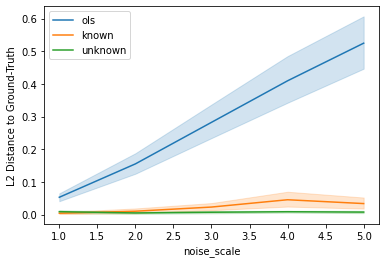

[Text(0.5, 0, 'noise_scale'), Text(0, 0.5, 'L1 Distance to Ground-Truth')]

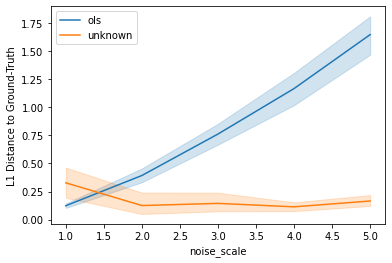

In [31]:
sns.lineplot(data=logs, x='noise_scale', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='noise_scale', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_scale', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='noise_scale', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [59]:
res.lambda_.inverse()

tensor([[2.9077]], grad_fn=<InverseBackward>)

In [142]:
ols_var

tensor([[6.6700]])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

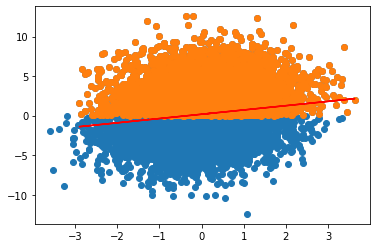

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])

In [6]:
test = ch.nn.Linear(in_features=1, out_features=1)

In [8]:
test.copy_()

ModuleAttributeError: 'Linear' object has no attribute 'copy_'

In [4]:
ch.ones(1).clone()

tensor([1.])